# Sunrise Housing Case study

## Objective

Identify prospective properties to invest in based on the prediction of the sale price of such properties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

from IPython.display import Latex

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# load the dataset
inp0 = pd.read_csv('train.csv', header=0)
inp0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### I.  Data understanding

Following features are total values found in the dataset:<br>
*TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF <br>
TotRmsAbvGrd = BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr<br>
GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF<br>*
However, cannot drop the individual features that sum up to the totals until the correlation matrix is known under EDA

**1. Number of rows, columns and column names**

In [3]:
inp0.shape

(1460, 81)

In [4]:
print(list(inp0.columns))

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

**Observation**<br>
1. Number of rows = 1460. Number of columns = 81.<br>
2. Large number of columns implies that many will need to be dropped or they can be used to derive new metrics.

**2. Drop feature Id**<br>
Id is used for identification and is not known when the unseen data is processed.

In [5]:
col_drop = ['Id']

**3. Presence of NaN or Null**

In [6]:
#presence of NaN values & Null values
print('NaN : ' , list( [inp0[i].isna().sum() for i in inp0.columns]))
print('Null: ', list( [inp0[i].isnull().sum() for i in inp0.columns]))

NaN :  [0, 0, 0, 259, 0, 0, 1369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 37, 37, 38, 37, 0, 38, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 690, 81, 81, 81, 0, 0, 81, 81, 0, 0, 0, 0, 0, 0, 0, 1453, 1179, 1406, 0, 0, 0, 0, 0, 0]
Null:  [0, 0, 0, 259, 0, 0, 1369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 37, 37, 38, 37, 0, 38, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 690, 81, 81, 81, 0, 0, 81, 81, 0, 0, 0, 0, 0, 0, 0, 1453, 1179, 1406, 0, 0, 0, 0, 0, 0]


**Observation**<br>
The number of NaN and Null values are same for all the columns in the dataset. <br>
**Action**<br>
Find columns and the percentage of the NaN values which are non-zero to determine further action.

In [7]:
#many NaN & Null values present; find the columns names for more information and store in a dictionary with percentages
inp0_dict0 = {str(i) : round(((inp0[i].isna().sum()/inp0.shape[0])* 100),2) for i in inp0.columns if inp0[i].isna().sum()>0 }

#sort the dictionary with highest percentages first and print; returns a tuple
inp0_dict1 = sorted( inp0_dict0.items() , key = lambda x : x[1], reverse=True)

#convert tuple to dict
inp0_dict0 = { }
inp0_dict0 = { key:value for key,value in inp0_dict1 }

#print columns with NaN values
print(inp0_dict0)

{'PoolQC': 99.52, 'MiscFeature': 96.3, 'Alley': 93.77, 'Fence': 80.75, 'FireplaceQu': 47.26, 'LotFrontage': 17.74, 'GarageType': 5.55, 'GarageYrBlt': 5.55, 'GarageFinish': 5.55, 'GarageQual': 5.55, 'GarageCond': 5.55, 'BsmtExposure': 2.6, 'BsmtFinType2': 2.6, 'BsmtQual': 2.53, 'BsmtCond': 2.53, 'BsmtFinType1': 2.53, 'MasVnrType': 0.55, 'MasVnrArea': 0.55, 'Electrical': 0.07}


**Observation**<br>
Drop the columns with very high percentage of NaN values ie above 30%. These columns have NA values meaning None for categorical variables implying the absence of the said feature which is very high. For remaining columns, find the common number of rows satisfying them and drop them if required else, impute these columns.

In [8]:
#dropping columns with missing values above 30%
col_drop.extend([key for key,value in inp0_dict0.items() if value >= 30])
inp0.drop(col_drop, axis=1, inplace=True)

**4. Determine columns with high number of zeros or categorical features with values highly favouring one value and add them to drop list**<br>
    Since number of rows are less, none will be removed and the missing values will be imputed.

In [9]:
#find all columns with high number of zeroes(30% of zeros ok in each column) and drop them
inp0_0col = [i for i in inp0.columns if (inp0[i] == 0).sum()>(0.3*(inp0.shape[0]))]
col_drop=[]
col_drop.extend(inp0_0col)

#find categorical features favouring highly only 1 value; highest count is more than 85% of the total rows; no variance
col_drop.extend(
    [i for i in inp0.select_dtypes(include='object').columns if inp0[i].value_counts().max() > (0.8*(inp0.shape[0]))])

In [10]:
#find total  number of None per feature 
print('Null: ', list( [(inp0[i]=='None').sum() for i in inp0.columns if (inp0[i]=='None').sum()>0 ]))

Null:  [864]


A single feature has 864 entries of None rendering it ineffective for further analysis. Therefore, it must be dropped.

In [11]:
#categorical features containing high number of None; other categorical features have the same value as NA
col_drop.extend([i for i in inp0.select_dtypes(include='object').columns if (inp0[i] == 'None').sum()>0])
inp0.drop(col_drop, axis=1, inplace=True)

In [12]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1460 non-null   int64  
 1   MSZoning      1460 non-null   object 
 2   LotFrontage   1201 non-null   float64
 3   LotArea       1460 non-null   int64  
 4   LotShape      1460 non-null   object 
 5   LotConfig     1460 non-null   object 
 6   Neighborhood  1460 non-null   object 
 7   HouseStyle    1460 non-null   object 
 8   OverallQual   1460 non-null   int64  
 9   OverallCond   1460 non-null   int64  
 10  YearBuilt     1460 non-null   int64  
 11  YearRemodAdd  1460 non-null   int64  
 12  RoofStyle     1460 non-null   object 
 13  Exterior1st   1460 non-null   object 
 14  Exterior2nd   1460 non-null   object 
 15  ExterQual     1460 non-null   object 
 16  Foundation    1460 non-null   object 
 17  BsmtQual      1423 non-null   object 
 18  BsmtExposure  1422 non-null 

### II. Data cleaning & manipulation

In [13]:
# copy inital dataset
inp1 = inp0.copy()

**1. Fix the data types of all features**<br>
MSSubClass,OverallQual,OverallCond : convert to object from int64/float64 since it is a categorical value

In [14]:
inp1['MSSubClass'] = inp1['MSSubClass'].astype('str')
inp1['OverallQual'] = inp1['OverallQual'].astype('str')
inp1['OverallCond'] = inp1['OverallCond'].astype('str')

**Observation**<br>
Sales price is ideally in float but since the dataset contains integer values for the properties, it would be best to retain
this

**2. Impute missing values for categorical & continous features**<br>
**2.1 Categorical features**

In [15]:
#impute categorial features with mode

#find all the categorial features with missing values
cat_impute = [ str(i) for i in inp1.select_dtypes(include='object') if (inp1[str(i)].isna().sum()>0) ]

#impute the missing values with mode
for i in cat_impute:    
    inp1[str(i)] = inp1[str(i)].fillna(str(inp1[str(i)].mode()[0]))    

#confirm that no categorical feature has any missing value
print([ str(i) for i in inp1.select_dtypes(include='object') if (inp1[str(i)].isna().sum()>0) ])

[]


**2.2 Continuous features**

In [16]:
#impute continuous features with mean

#find all the continuous features with missing values
print([str(i) for i in inp1.select_dtypes(include=['int64','float64']) if(inp1[str(i)].isna().sum()>0)])

['LotFrontage', 'GarageYrBlt']


Dealing with feature LotFrontage

In [17]:
#check if outliers present; cannot plot boxplot because of missing values
inp1['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [18]:
#LotFrontage: impute the missing values with median within subset on Neighborhood(assumption that LotFrontage will be similar 
# within same neighbourhoods) since from above can see indications of outliers; convert from float to int
inp1['LotFrontage'] = inp1.groupby(by='Neighborhood')['LotFrontage'].apply( lambda x : x.fillna(x.median()) )
inp1['LotFrontage'] = inp1['LotFrontage'].astype('int64')

print('Count of null values present in feature LotFrontage:',inp1['LotFrontage'].isna().sum())

Count of null values present in feature LotFrontage: 0


Dealing with feature GarageYrBlt

In [19]:
#'GarageYrBlt' even though is of type float64 is a date datatype and therefore is not continuous but categorical

#find list of features names starting with Garage to figure out if there is a Garage or not
x_list = [ str(i) for i in inp1.columns if str(i).startswith('Garage')]

#contain the list of rows in a dataframe
x_df = inp1[x_list][inp1.GarageYrBlt.isna()]
x_df.head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,Attchd,NaN,Unf,0,0
48,Attchd,NaN,Unf,0,0
78,Attchd,NaN,Unf,0,0
88,Attchd,NaN,Unf,0,0
89,Attchd,NaN,Unf,0,0


In [20]:
#find the sum of the feature GarageArea for this dataframe
print('Total sum of garage area where GarageYrBlt is missing: ' ,x_df['GarageArea'].sum())

Total sum of garage area where GarageYrBlt is missing:  0


**Observation**<br>
Since the garage area is zero, this implies that there is no garage in these properties and therefore the year built for 
garage will be 0. Therfore impute this categorical value with 0.

In [21]:
inp1['GarageYrBlt'] = inp1['GarageYrBlt'].fillna(0) 

#confirm whether any missing values are present
print('Number of missing values in GarageYrBlt: ',inp1['GarageYrBlt'].isna().sum())

Number of missing values in GarageYrBlt:  0


**Observation**<br>
All values are imputed now for both categorial & continuous features.

**3. Reduce the number of categories within a categorical feature & map the categories to string values**<br>
Categories which have lesser number of occurences(10%) within each categorical feature can be replaced with a new categorical value named 'Others'. Such categorical values play a limited role in model building as their occurence is very less in comparison to the rest and yet they cannot be ignored. Also, this is done to reduce the number of dummy variables that will be created during data preparation prior to modelling which in turn will reduce the complexity of the model. 

**3.1 Determine the current state of the categories within the categorical features**

In [22]:
#list of categorical values and their counts
x_dict = {}
x_dict = { str(i):inp1[str(i)].value_counts() for i in inp1.select_dtypes(include='object') } 
for key, value in x_dict.items():
    print(key)
    print(value)

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64
HouseStyle
1Story    726
2Story    445
1.5Fin    154

In [23]:
#replace the occurence of 10% and less with new value 'Others'
cat_limit = 0.10*inp1.shape[0]
for i in inp1.select_dtypes(include='object'):
    cat_limit_list=[]
    for value,count in inp1[str(i)].value_counts().items():
        if count <= cat_limit:
            cat_limit_list.append(str(value))
    inp1[str(i)] = inp1[str(i)].apply(lambda x : 'Others' if x in cat_limit_list else x)

**3.2 Intermediate state of the categories within the categorical variables**

In [24]:
#list of categorical values and their counts
x_dict = {}
x_dict = { str(i):inp1[str(i)].value_counts() for i in inp1.select_dtypes(include='object') } 
for key, value in x_dict.items():
    print(key)
    print(value)

MSSubClass
Others    625
20        536
60        299
Name: MSSubClass, dtype: int64
MSZoning
RL        1151
RM         218
Others      91
Name: MSZoning, dtype: int64
LotShape
Reg       925
IR1       484
Others     51
Name: LotShape, dtype: int64
LotConfig
Inside    1052
Corner     263
Others     145
Name: LotConfig, dtype: int64
Neighborhood
Others     1085
NAmes       225
CollgCr     150
Name: Neighborhood, dtype: int64
HouseStyle
1Story    726
2Story    445
1.5Fin    154
Others    135
Name: HouseStyle, dtype: int64
OverallQual
5         397
6         374
7         319
Others    202
8         168
Name: OverallQual, dtype: int64
OverallCond
5         821
6         252
7         205
Others    182
Name: OverallCond, dtype: int64
RoofStyle
Gable     1141
Hip        286
Others      33
Name: RoofStyle, dtype: int64
Exterior1st
VinylSd    515
Others     297
HdBoard    222
MetalSd    220
Wd Sdng    206
Name: Exterior1st, dtype: int64
Exterior2nd
VinylSd    504
Others     338
MetalSd    214
H

**3.3 Map the categorical values into string values**

In [25]:
#mapping to new values for easy understanding by checking with data dictionary
inp1['MSSubClass'] = inp1['MSSubClass'].map({'20':'1_StoryNewAll', '60':'2_StoryNew', 'Others':'Others'})
inp1['MSZoning'] = inp1['MSZoning'].map({'RL':'ResLowDensity', 'RM':'ResMedDensity', 'Others':'Others'})
inp1['LotShape'] = inp1['LotShape'].map({'Reg':'Regular', 'IR1':'Slightly Irregular', 'Others':'Others'})
inp1['Neighborhood'] = inp1['Neighborhood'].map({'NAmes':'Names', 'CollgCr':'College Creek', 'Others':'Others'})
inp1['HouseStyle'] = inp1['HouseStyle'].map({'1Story':'1 Story', '2Story':'2 Story','1.5Fin':'1.5 StoryFin','Others':'Others'})
inp1['OverallQual'] = inp1['OverallQual'].map({'5':'Avg', '6':'Above Avg','7':'Good','8':'Very Good' ,'Others':'Others'})
inp1['OverallCond'] = inp1['OverallCond'].map({'5':'Avg', '6':'Above Avg','7':'Good','Others':'Others'})
inp1['Exterior1st'] = inp1['Exterior1st'].map({'VinylSd':'VinylSiding', 'HdBoard':'HardBoard','MetalSd':'MetalSiding',
                                               'Wd Sdng':'WoodSiding','Others':'Others'})
inp1['Exterior2nd'] = inp1['Exterior2nd'].map({'VinylSd':'VinylSiding', 'HdBoard':'HardBoard','MetalSd':'MetalSiding',
                                               'Wd Sdng':'WoodSiding', 'Others':'Others'})
inp1['ExterQual'] = inp1['ExterQual'].map({'TA':'Typical', 'Gd':'Good', 'Others':'Others'})
inp1['Foundation'] = inp1['Foundation'].map({'PConc':'PouredContrete', 'CBlock':'CinderBlock', 'Others':'Others'})
inp1['BsmtQual'] = inp1['BsmtQual'].map({'TA':'Typical', 'Gd':'Good', 'Others':'Others'})
inp1['BsmtExposure'] = inp1['BsmtExposure'].map({'No':'No', 'Av':'Avg', 'Others':'Others'})
inp1['BsmtFinType1'] = inp1['BsmtFinType1'].map({'Unf':'Unfin', 'GLQ':'GoodLivQtr','ALQ':'AvgLivQtr',
                                                 'BLQ':'BlwAvgLivQtr' ,'Others':'Others'})
inp1['HeatingQC'] = inp1['HeatingQC'].map({'Ex':'Excellant','TA':'Typical', 'Gd':'Good', 'Others':'Others'})
inp1['KitchenQual'] = inp1['KitchenQual'].map({'TA':'Typical', 'Gd':'Good', 'Others':'Others'})
inp1['GarageType'] = inp1['GarageType'].map({'Attchd':'Attached', 'Detchd':'Detached', 'Others':'Others'})
inp1['GarageFinish'] = inp1['GarageFinish'].map({'Unf':'UnFin', 'RFn':'RoughFin', 'Fin':'Fin'})

In [26]:
#list of categorical values and their counts after mapping
x_dict = {}
x_dict = { str(i):inp1[str(i)].value_counts() for i in inp1.select_dtypes(include='object') } 
for key, value in x_dict.items():
    print(key)
    print(value)

MSSubClass
Others           625
1_StoryNewAll    536
2_StoryNew       299
Name: MSSubClass, dtype: int64
MSZoning
ResLowDensity    1151
ResMedDensity     218
Others             91
Name: MSZoning, dtype: int64
LotShape
Regular               925
Slightly Irregular    484
Others                 51
Name: LotShape, dtype: int64
LotConfig
Inside    1052
Corner     263
Others     145
Name: LotConfig, dtype: int64
Neighborhood
Others           1085
Names             225
College Creek     150
Name: Neighborhood, dtype: int64
HouseStyle
1 Story         726
2 Story         445
1.5 StoryFin    154
Others          135
Name: HouseStyle, dtype: int64
OverallQual
Avg          397
Above Avg    374
Good         319
Others       202
Very Good    168
Name: OverallQual, dtype: int64
OverallCond
Avg          821
Above Avg    252
Good         205
Others       182
Name: OverallCond, dtype: int64
RoofStyle
Gable     1141
Hip        286
Others      33
Name: RoofStyle, dtype: int64
Exterior1st
VinylSiding    515

**4 Create derived metrics and drop the columns from which new metric is derived**

**4.1 MoSold, YrSold : join the 2 columns to derive a new metric with month and year**

In [27]:
inp1['mySold'] = inp1['YrSold'].astype('str') + '-' + inp1['MoSold'].astype('str')
col_drop=[]
col_drop.extend(['MoSold','YrSold'])

In [28]:
#convert the year columns into datetime format for further manipulation
inp1['YearBuilt']=inp1['YearBuilt'].apply(lambda x:pd.to_datetime(str(x),format='%Y'))
inp1['YearRemodAdd']=inp1['YearRemodAdd'].apply(lambda x:pd.to_datetime(str(x),format='%Y'))

inp1['GarageYrBlt']=inp1['GarageYrBlt'].astype('int64')
inp1['GarageYrBlt']=inp1['GarageYrBlt'].apply(lambda x:pd.to_datetime(str(x),format='%Y') if x != 0 else 0)

inp1['mySold']=inp1['mySold'].apply(lambda x:pd.to_datetime(str(x),format='%Y-%m'))

**4.2 Calculate age of property using YearBuilt, YearRemodAdd, GarageYrBlt & mySold**<br>
The new metrics will have fractional years since the month when the property was sold is known.

In [29]:
#get an idea of how the dates look in comparision to each other
inp1[['YearBuilt','YearRemodAdd','mySold','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,mySold,GarageYrBlt
0,2003-01-01,2003-01-01,2008-02-01,2003-01-01 00:00:00
1,1976-01-01,1976-01-01,2007-05-01,1976-01-01 00:00:00
2,2001-01-01,2002-01-01,2008-09-01,2001-01-01 00:00:00
3,1915-01-01,1970-01-01,2006-02-01,1998-01-01 00:00:00
4,2000-01-01,2000-01-01,2008-12-01,2000-01-01 00:00:00


In [30]:
#difference between year when built and year when sold in fractional years
inp1['AgeBuiltYr'] = round((inp1['mySold'].dt.to_period('M').view(dtype='int64') 
                            - inp1['YearBuilt'].dt.to_period('M').view(dtype='int64'))/12,2)

#difference between year remodelled and year sold in fractional years
inp1['AgeRemodYr'] = inp1.apply(lambda x : 0 if x.YearBuilt==x.YearRemodAdd
     else ( relativedelta.relativedelta(x.mySold,x.YearRemodAdd).years + 
           round((relativedelta.relativedelta(x.mySold,x.YearRemodAdd).months/12),2) ), axis=1 )

#difference between year sold & garage built when garage built is non zero
inp1['AgeGarageYr'] = inp1.apply(lambda x : 0 if x.GarageYrBlt == 0 
                else ( relativedelta.relativedelta(x.mySold,x.GarageYrBlt).years + 
                round((relativedelta.relativedelta(x.mySold,x.GarageYrBlt).months/12),2) ), axis=1 )

col_drop.extend(['YearBuilt','YearRemodAdd','mySold','GarageYrBlt'])

In [31]:
#check data set for the new metrics
inp1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,GarageFinish,GarageCars,GarageArea,MoSold,YrSold,SalePrice,mySold,AgeBuiltYr,AgeRemodYr,AgeGarageYr
0,2_StoryNew,ResLowDensity,65,8450,Regular,Inside,College Creek,2 Story,Good,Avg,...,RoughFin,2,548,2,2008,208500,2008-02-01,5.08,0.00,5.08
1,1_StoryNewAll,ResLowDensity,80,9600,Regular,Others,Others,1 Story,Above Avg,Others,...,RoughFin,2,460,5,2007,181500,2007-05-01,31.33,0.00,31.33
2,2_StoryNew,ResLowDensity,68,11250,Slightly Irregular,Inside,College Creek,2 Story,Good,Avg,...,RoughFin,2,608,9,2008,223500,2008-09-01,7.67,6.67,7.67
3,Others,ResLowDensity,60,9550,Slightly Irregular,Corner,Others,2 Story,Good,Avg,...,UnFin,3,642,2,2006,140000,2006-02-01,91.08,36.08,8.08
4,2_StoryNew,ResLowDensity,84,14260,Slightly Irregular,Others,Others,2 Story,Very Good,Avg,...,RoughFin,3,836,12,2008,250000,2008-12-01,8.92,0.00,8.92


In [32]:
#drop columns
inp1.drop(col_drop, axis=1, inplace=True)
col_drop=[]

In [33]:
#features after data cleaning & manipulation
inp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1460 non-null   object 
 1   MSZoning      1460 non-null   object 
 2   LotFrontage   1460 non-null   int64  
 3   LotArea       1460 non-null   int64  
 4   LotShape      1460 non-null   object 
 5   LotConfig     1460 non-null   object 
 6   Neighborhood  1460 non-null   object 
 7   HouseStyle    1460 non-null   object 
 8   OverallQual   1460 non-null   object 
 9   OverallCond   1460 non-null   object 
 10  RoofStyle     1460 non-null   object 
 11  Exterior1st   1460 non-null   object 
 12  Exterior2nd   1460 non-null   object 
 13  ExterQual     1460 non-null   object 
 14  Foundation    1460 non-null   object 
 15  BsmtQual      1460 non-null   object 
 16  BsmtExposure  1460 non-null   object 
 17  BsmtFinType1  1460 non-null   object 
 18  BsmtUnfSF     1460 non-null 

**Result**<br>
All data cleaning and manipulation is now complete. <br>
There are no missing values in any of the features.

### III. Expolatory Data Analysis

**1. Find outliers within continuous values**

In [34]:
#find the statistical values of the continuous values 
[inp1[str(i)].describe() for i in inp1.select_dtypes(exclude='object')]

[count    1460.000000
 mean       70.189041
 std        22.433083
 min        21.000000
 25%        60.000000
 50%        70.000000
 75%        80.000000
 max       313.000000
 Name: LotFrontage, dtype: float64,
 count      1460.000000
 mean      10516.828082
 std        9981.264932
 min        1300.000000
 25%        7553.500000
 50%        9478.500000
 75%       11601.500000
 max      215245.000000
 Name: LotArea, dtype: float64,
 count    1460.000000
 mean      567.240411
 std       441.866955
 min         0.000000
 25%       223.000000
 50%       477.500000
 75%       808.000000
 max      2336.000000
 Name: BsmtUnfSF, dtype: float64,
 count    1460.000000
 mean     1057.429452
 std       438.705324
 min         0.000000
 25%       795.750000
 50%       991.500000
 75%      1298.250000
 max      6110.000000
 Name: TotalBsmtSF, dtype: float64,
 count    1460.000000
 mean     1162.626712
 std       386.587738
 min       334.000000
 25%       882.000000
 50%      1087.000000
 75%      

**Observation**<br>
Cursory view of the above table gives following features which may have outliers:<br>
*LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice,AgeBuiltYr,AgeRemodYr,AgeGarageYr*<br>
Therefore plot boxplot for each of the features to check further.

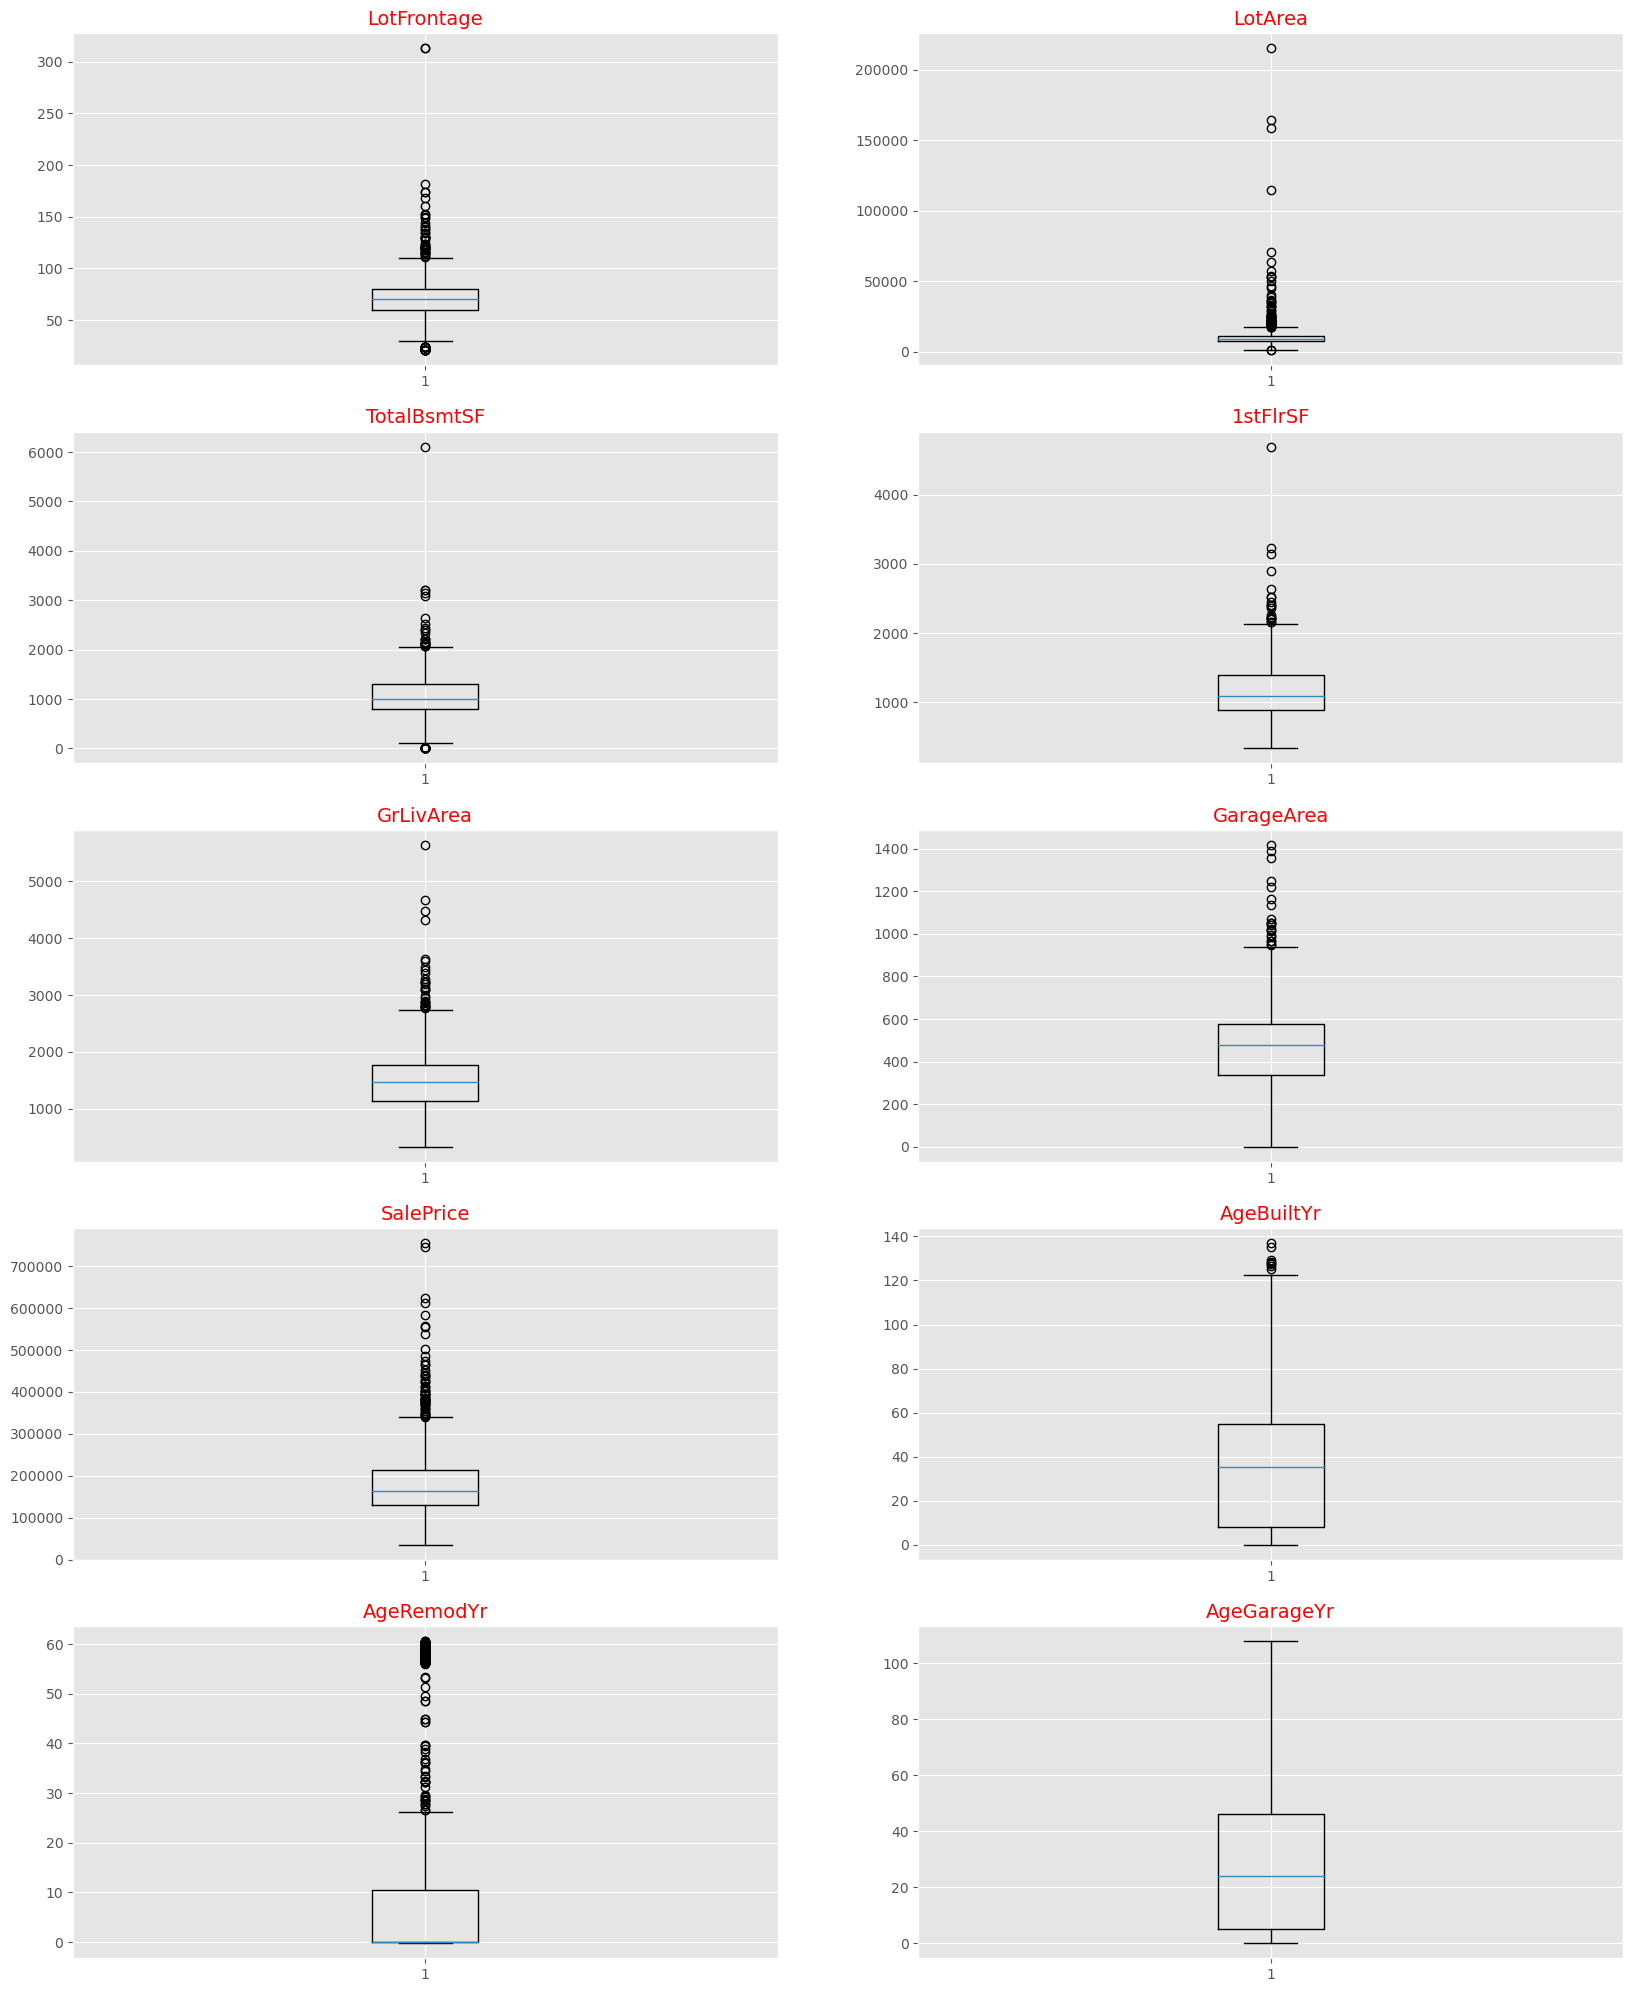

In [35]:
plt.figure(figsize=(20,25))
x_list = []
x_list.extend(['LotFrontage','LotArea','TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea','SalePrice','AgeBuiltYr',
               'AgeRemodYr','AgeGarageYr'])
p=1
for i in x_list:
    plt.subplot(5,2,p)
    plt.boxplot(inp1[str(i)])
    plt.title(str(i),fontdict={'fontsize':14,'fontweight':5,'color':'Red'})
    p += 1

plt.show()

**Observation**<br>
There are clear indications of outliers for features LotFrontage, LotArea, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea and SalePrice while the remaining features have continous values among the outliers.
Clearly there outliers can skew further data analysis, however the dataset provided is quite low, therefore
try to minimize the expense of removing the outliers as much as possible.

In [36]:
#copy into new data set; since not all conditions will satisfy the criteria to remove outliers, each feature has been 
#tackled separately

inp2 = inp1.copy()

inp2 = inp2[inp2['LotFrontage']<140]
inp2 = inp2[inp2['LotArea']<20000]
inp2 = inp2[inp2['TotalBsmtSF']<2300]
inp2 = inp2[inp2['1stFlrSF']<2300]
inp2 = inp2[inp2['GrLivArea']<3200]
inp2 = inp2[inp2['GarageArea']<1100]
inp2 = inp2[inp2['SalePrice']<500000]

inp2.shape

(1381, 36)

In [37]:
print('Number of observations dropped due to outliers :',inp1.shape[0]-inp2.shape[0])

Number of observations dropped due to outliers : 79


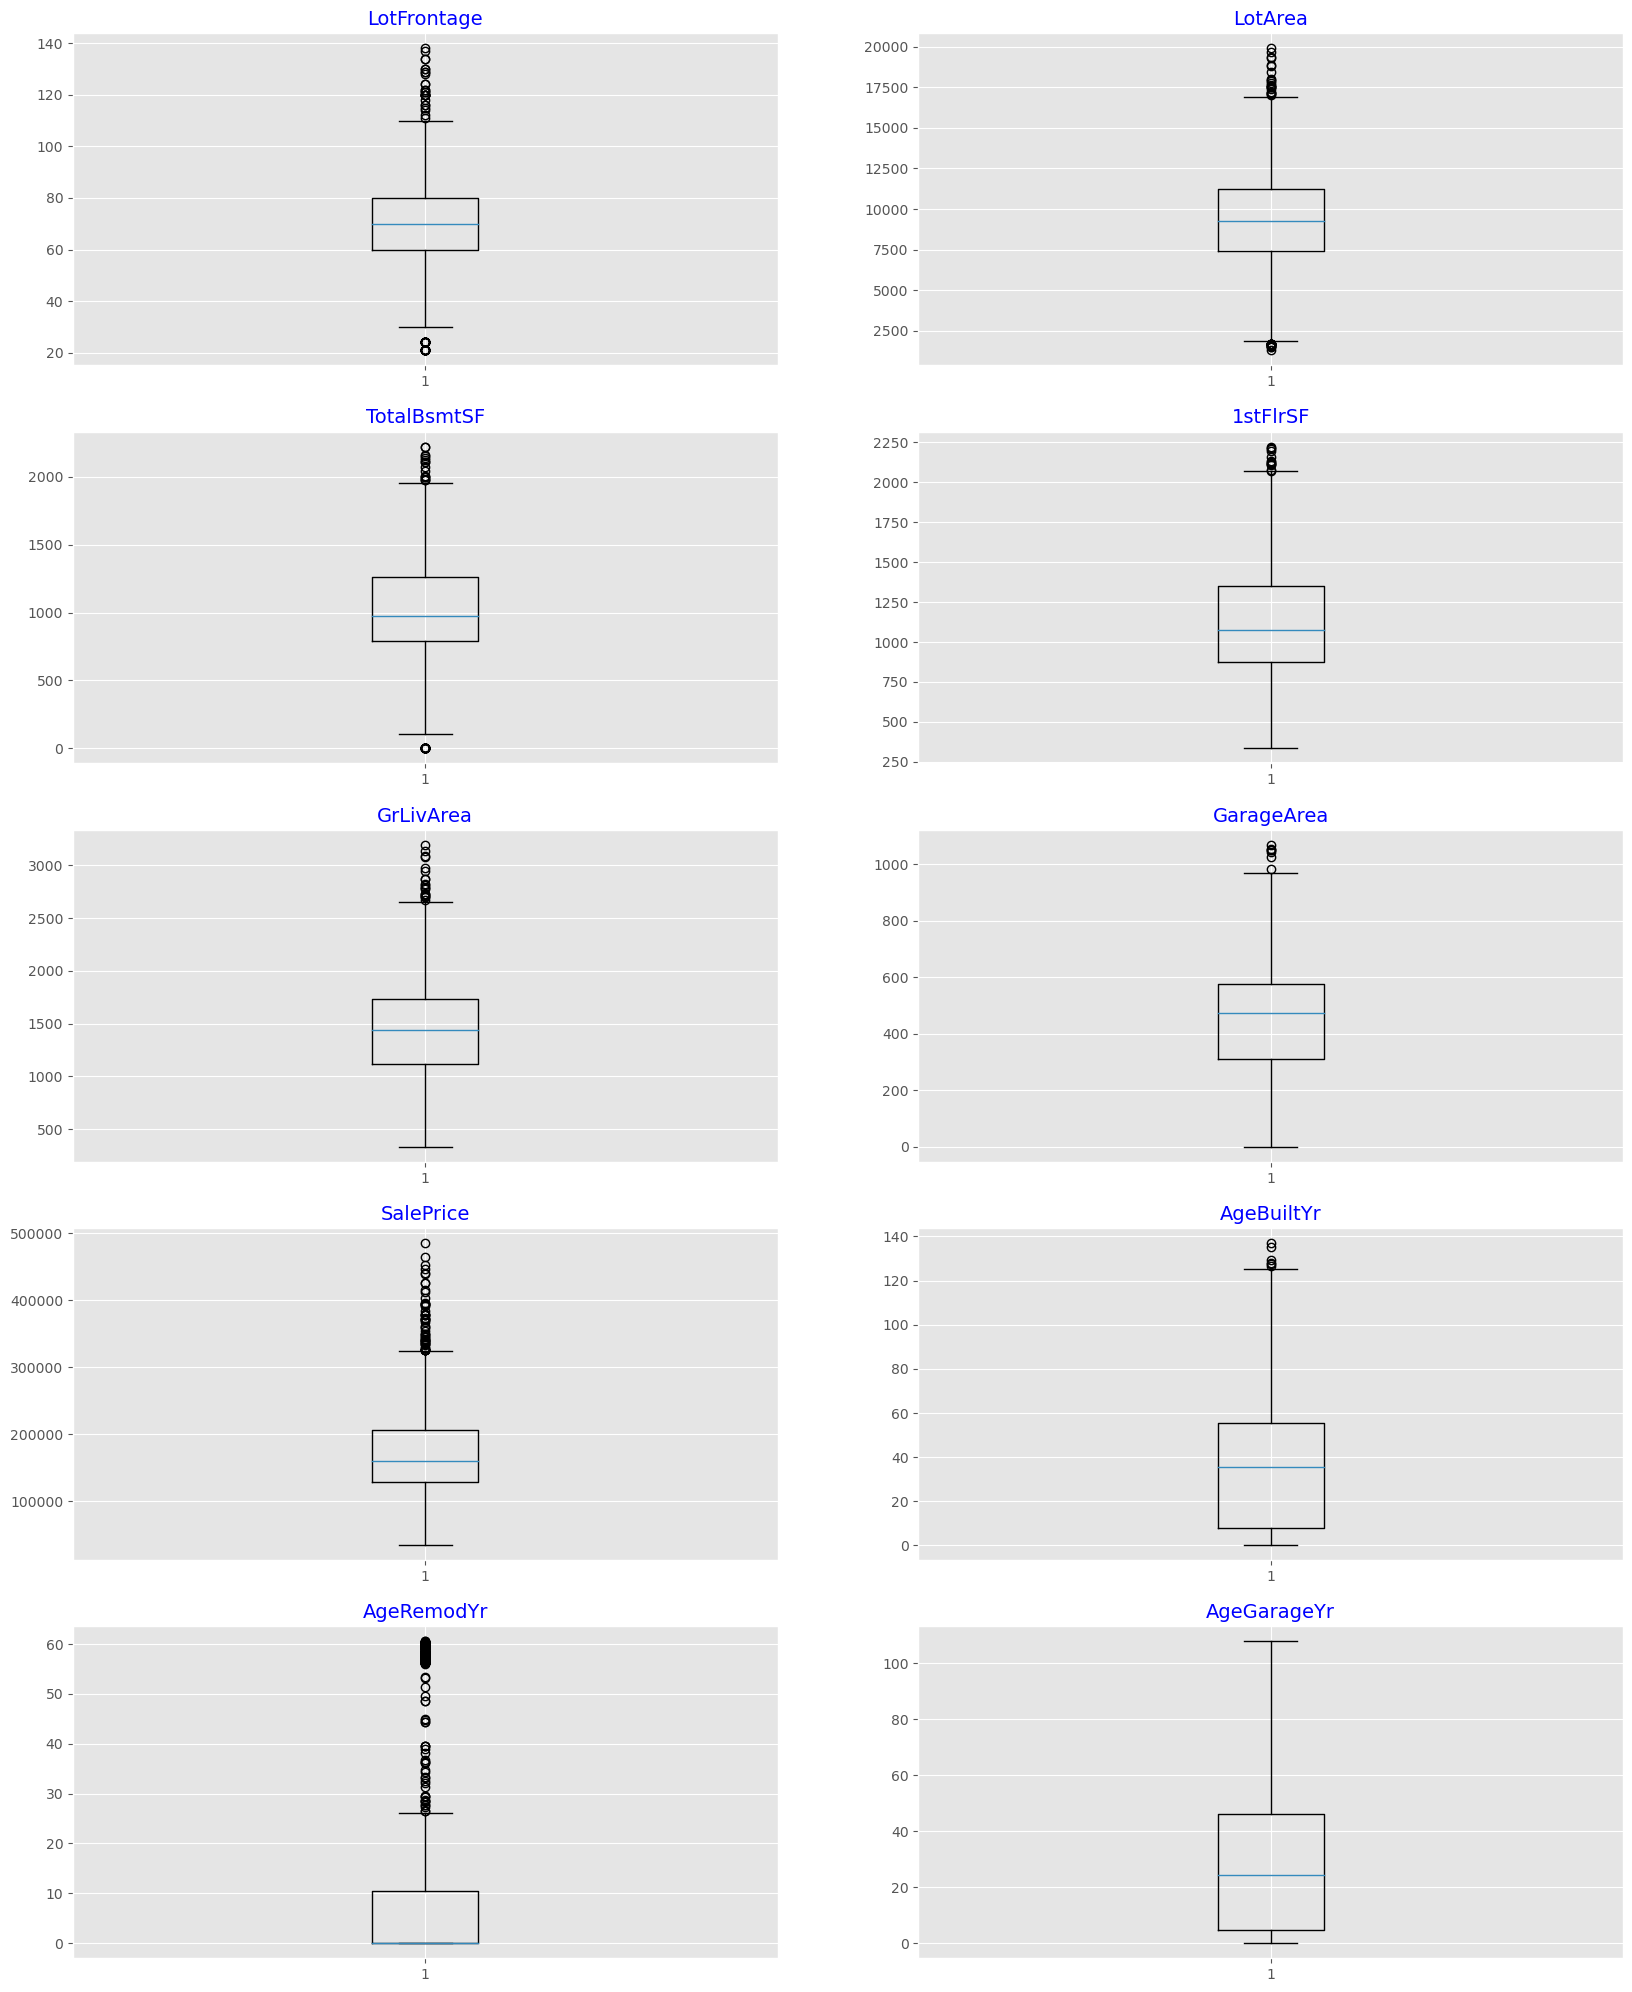

In [38]:
#plot the boxplots to determine if removing outliers makes the plots look good
plt.figure(figsize=(20,25))
p=1
for i in x_list:
    plt.subplot(5,2,p)
    plt.boxplot(inp2[str(i)])
    plt.title(str(i),fontdict={'fontsize':14,'fontweight':5,'color':'Blue'})
    p += 1

plt.show()

**Observation**<br>
Boxplots now look better after removing the outliers and there are continuous running datapoints beyond the upper whiskers of the plot.<br>
Since only 79 observations were dropped from a total of 1460 total observations, this is still good enough to proceed further.
However, let us check the percentiles to further confirm this.

**Action**<br>
Find the key perctiles for the notes features above to confirm whether the values are continuous.

In [39]:
#create dataframe based on percentiles to further check for outliers
y_list=[]
z_list=[]
q_list=[0.5, 0.75,0.90, 0.95, 0.97,0.98, 0.99]
for i in x_list:
    z_list=[]
    z_list.append(str(i))
    for j in q_list:
        z_list.append(round(inp2[str(i)].quantile(j),2))
    y_list.append(z_list)

y_df = pd.DataFrame(y_list,columns=['Feature','0.5','0.75','0.90','0.95','0.97','0.98','0.99'])
y_df

,Feature,0.5,0.75,0.90,0.95,0.97,0.98,0.99
0,LotFrontage,70.00,80.00,90.00,100.00,107.00,110.40,121.00
1,LotArea,9245.00,11207.00,13450.00,14774.00,16117.80,16651.80,17510.80
2,TotalBsmtSF,978.00,1261.00,1568.00,1709.00,1800.00,1868.40,1981.20
3,1stFlrSF,1072.00,1352.00,1640.00,1742.00,1844.00,1941.60,2050.60
4,GrLivArea,1440.00,1738.00,2090.00,2340.00,2520.60,2616.40,2727.60
5,GarageArea,473.00,576.00,732.00,836.00,869.20,888.40,924.00
6,SalePrice,159950.00,207000.00,269790.00,315500.00,338850.00,364069.00,394469.00
7,AgeBuiltYr,35.42,55.25,83.92,91.25,96.90,100.02,110.07
8,AgeRemodYr,0.00,10.50,56.50,58.25,59.33,59.58,60.19
9,AgeGarageYr,24.42,46.25,61.75,78.42,83.72,87.13,90.36


**Observations**<br>
Now we see all the features having continuous values and the boxplot looks good too. Assumption is not to remove any further
observations since the dataset is quite low and we may lose any pattern hidden in the provided dataset

**2. Correlation matrix in a heatmap**

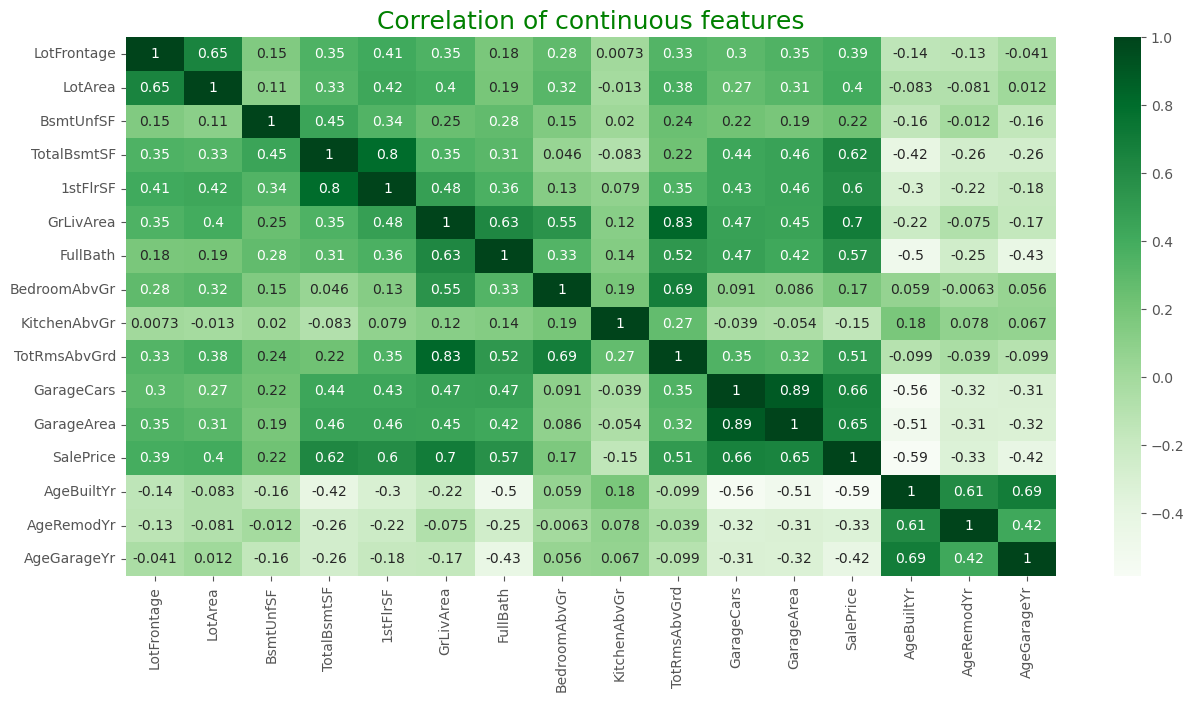

In [40]:
plt.figure(figsize=(15,7))
sns.heatmap(inp2.corr(), annot=True, cmap='Greens')
plt.title('Correlation of continuous features',fontdict={'fontsize':18,'fontweight':5,'color':'Green'})
plt.show()

**Observation**<br>
1. High correlation between dependent features *Sales Price* and independent features *TotalBsmtSF, 1stFlrSF, GrLivArea, 
FullBath, TotRmsAbvGrd,GarageCars & GarageArea*.<br>
2. Strong correlation between independent features *TotalBsmtSF & 1stFlrSF, 1stFlrSF & GrLivArea, GrLivArea & TotalRmsAbvGrd,
GrLivArea & FullBath, BedroomAbvGr & TotRmsAbvGrd, GarageCars & GarageArea, AgeBuiltYr & AgeGarageYr , 
AgeBuiltYr & AgeRemodYr*. This implies multicollinearity which we will confirm during model building.<br>
3. Correlation between the years and salesprice is negatively correlated.<br>
4. There is a negative correlation between the age of the properties esp from when it is built

**3. Visual comparison between dependent & independent variables**

**3.1 Pairplot of dependent & indepedent features**

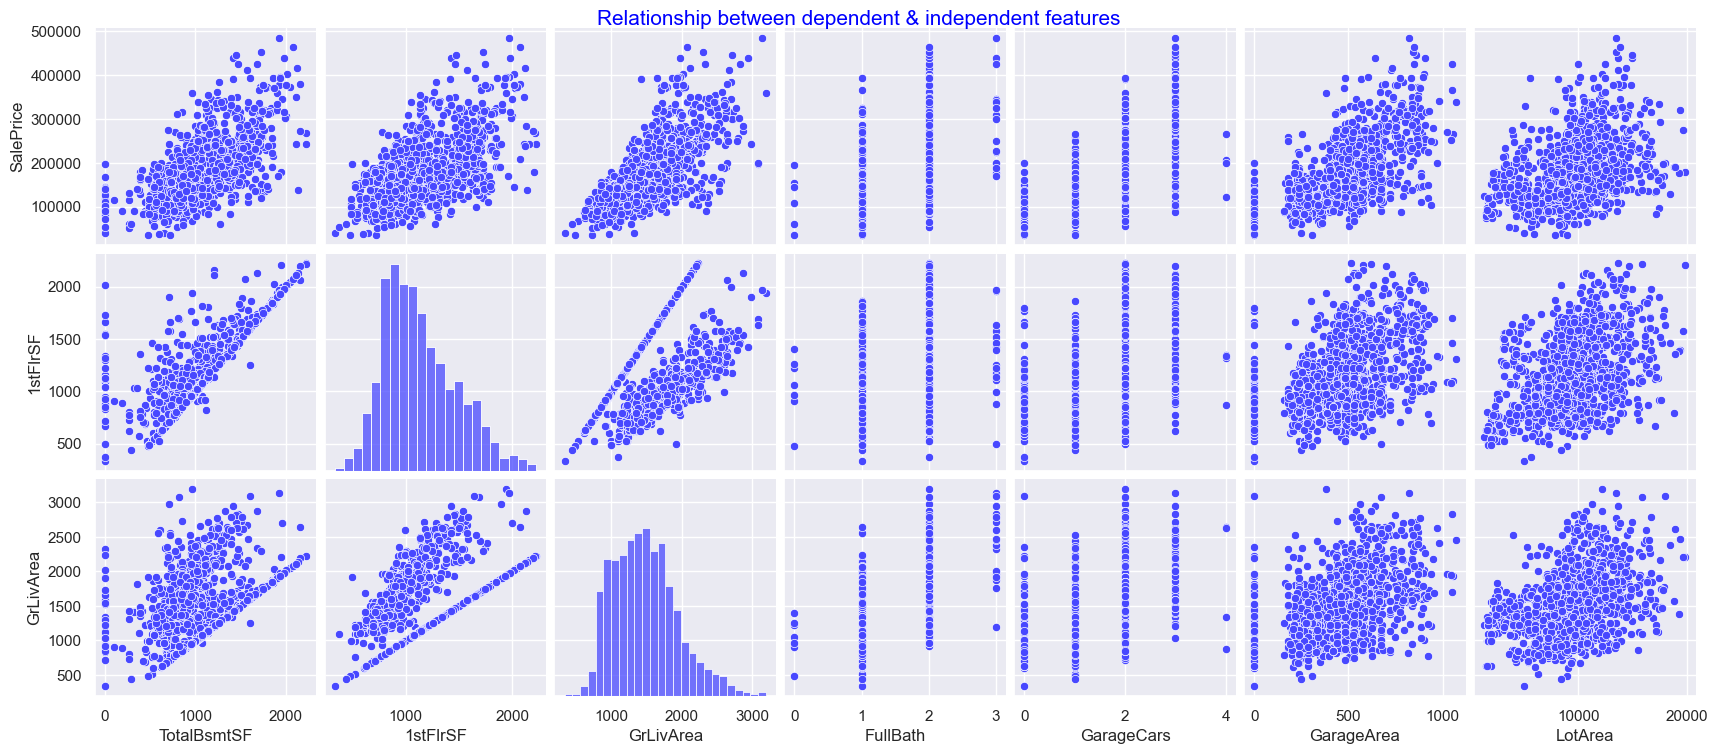

In [41]:
sns.set(palette='bwr')
g=sns.pairplot(inp2, x_vars=['TotalBsmtSF','1stFlrSF', 'GrLivArea','FullBath','GarageCars','GarageArea','LotArea'],
                 y_vars=['SalePrice','1stFlrSF','GrLivArea'])
g.fig.suptitle('Relationship between dependent & independent features',y=1,fontsize=15,color='Blue')
plt.show()

**Observation**<br>
*Sales price*
1. Positive correlation with TotalBsmtSf, 1stFlrSF and GrLivArea. 1stFlrSF is part of GrLivArea.<br>
2. Majority of the purchases are for 2 or 3 FullBath with a slight increase in sales price with increase in Full Bath.<br>
3. Maximum sales are for properties having a capacity of 3 garage cars. There is an increasing trend except for those 
properties with 4 garage cars.<br>
4. Positive correlation with GarageArea.<nr>

*1stFlrSF*<br>
1. Strong positive correlation with TotalBsmtFS & GrLivArea.<br>
2. Slight positive correlation with GarageArea.<br>

*GrLivArea*
1. Strong positive correlation with TotalBsmtFS & 1stFlrSf.<br>
2. Slight positive correlation with GarageArea.

**3.2 Scatter plot between numerical independent features**

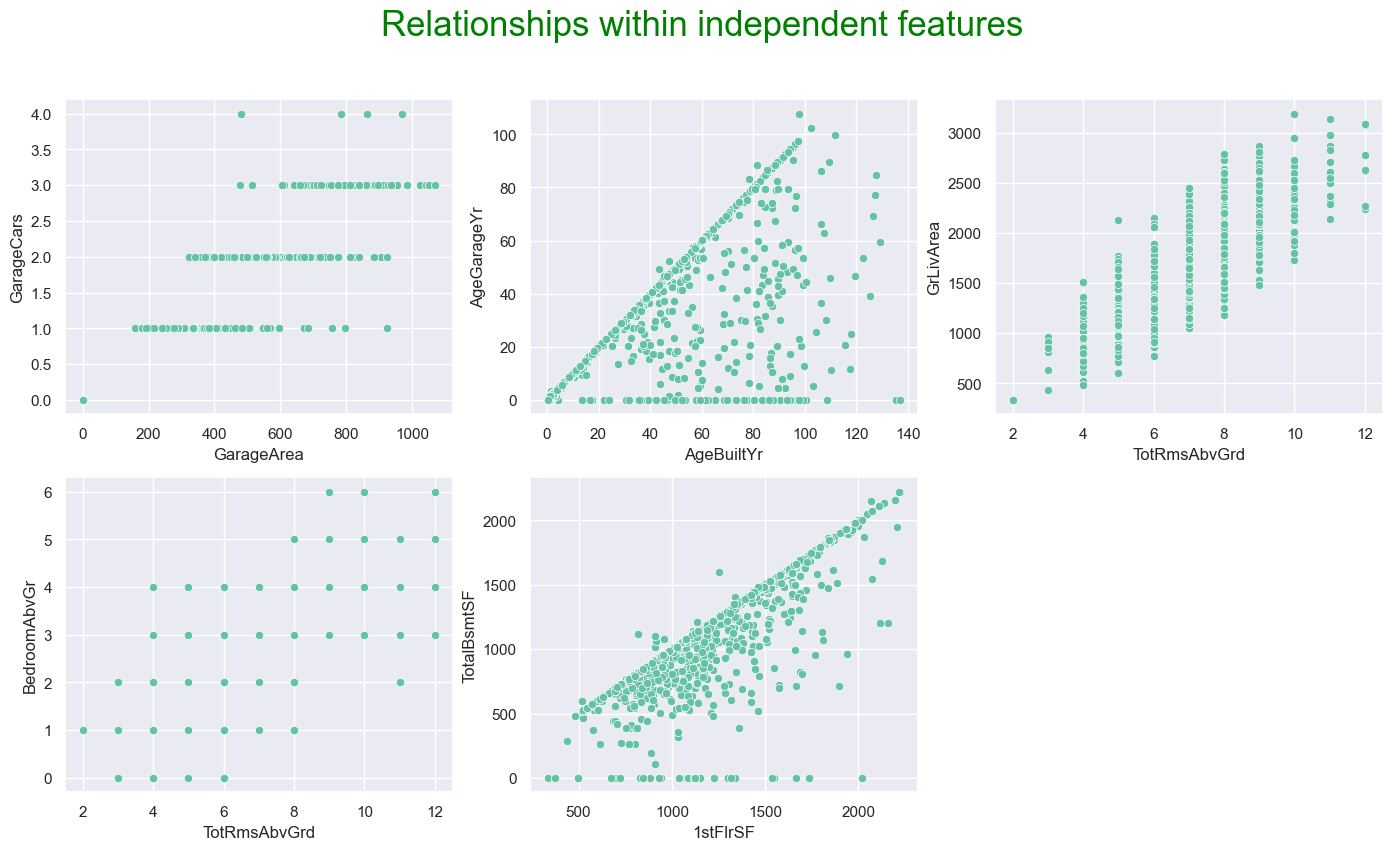

In [42]:
sns.set(palette='Set2')
plt.figure(figsize=(17,9))
plt.suptitle('Relationships within independent features',fontsize=25,color='Green')

plt.subplot(2,3,1)
sns.scatterplot(x=inp2['GarageArea'], y=inp2['GarageCars'])

plt.subplot(2,3,2)
sns.scatterplot(x=inp2['AgeBuiltYr'], y=inp2['AgeGarageYr'])

plt.subplot(2,3,3)
sns.scatterplot(x=inp2['TotRmsAbvGrd'], y=inp2['GrLivArea'])

plt.subplot(2,3,4)
sns.scatterplot(x=inp2['TotRmsAbvGrd'], y=inp2['BedroomAbvGr'])

plt.subplot(2,3,5)
sns.scatterplot(x=inp2['1stFlrSF'], y=inp2['TotalBsmtSF'])

plt.show()

**Observation**<br>
1. Even though garage area increases, the number of cars does not necessarily increase.<br>
2. Steady increase in the age of when the property was built and the year when garage was built.<br>
3. Steady increase when number of rooms increases as the property also increases.<br>
4. As the total rooms increases, there is a guarantee that the number of bedrooms also increases.<br>
5. There is a positive relation between the total basement area to the first floor surface area.

**4. Relationship between categorial features and sales price**

**4.1 Relation between categorical features & the number of sales in each category**

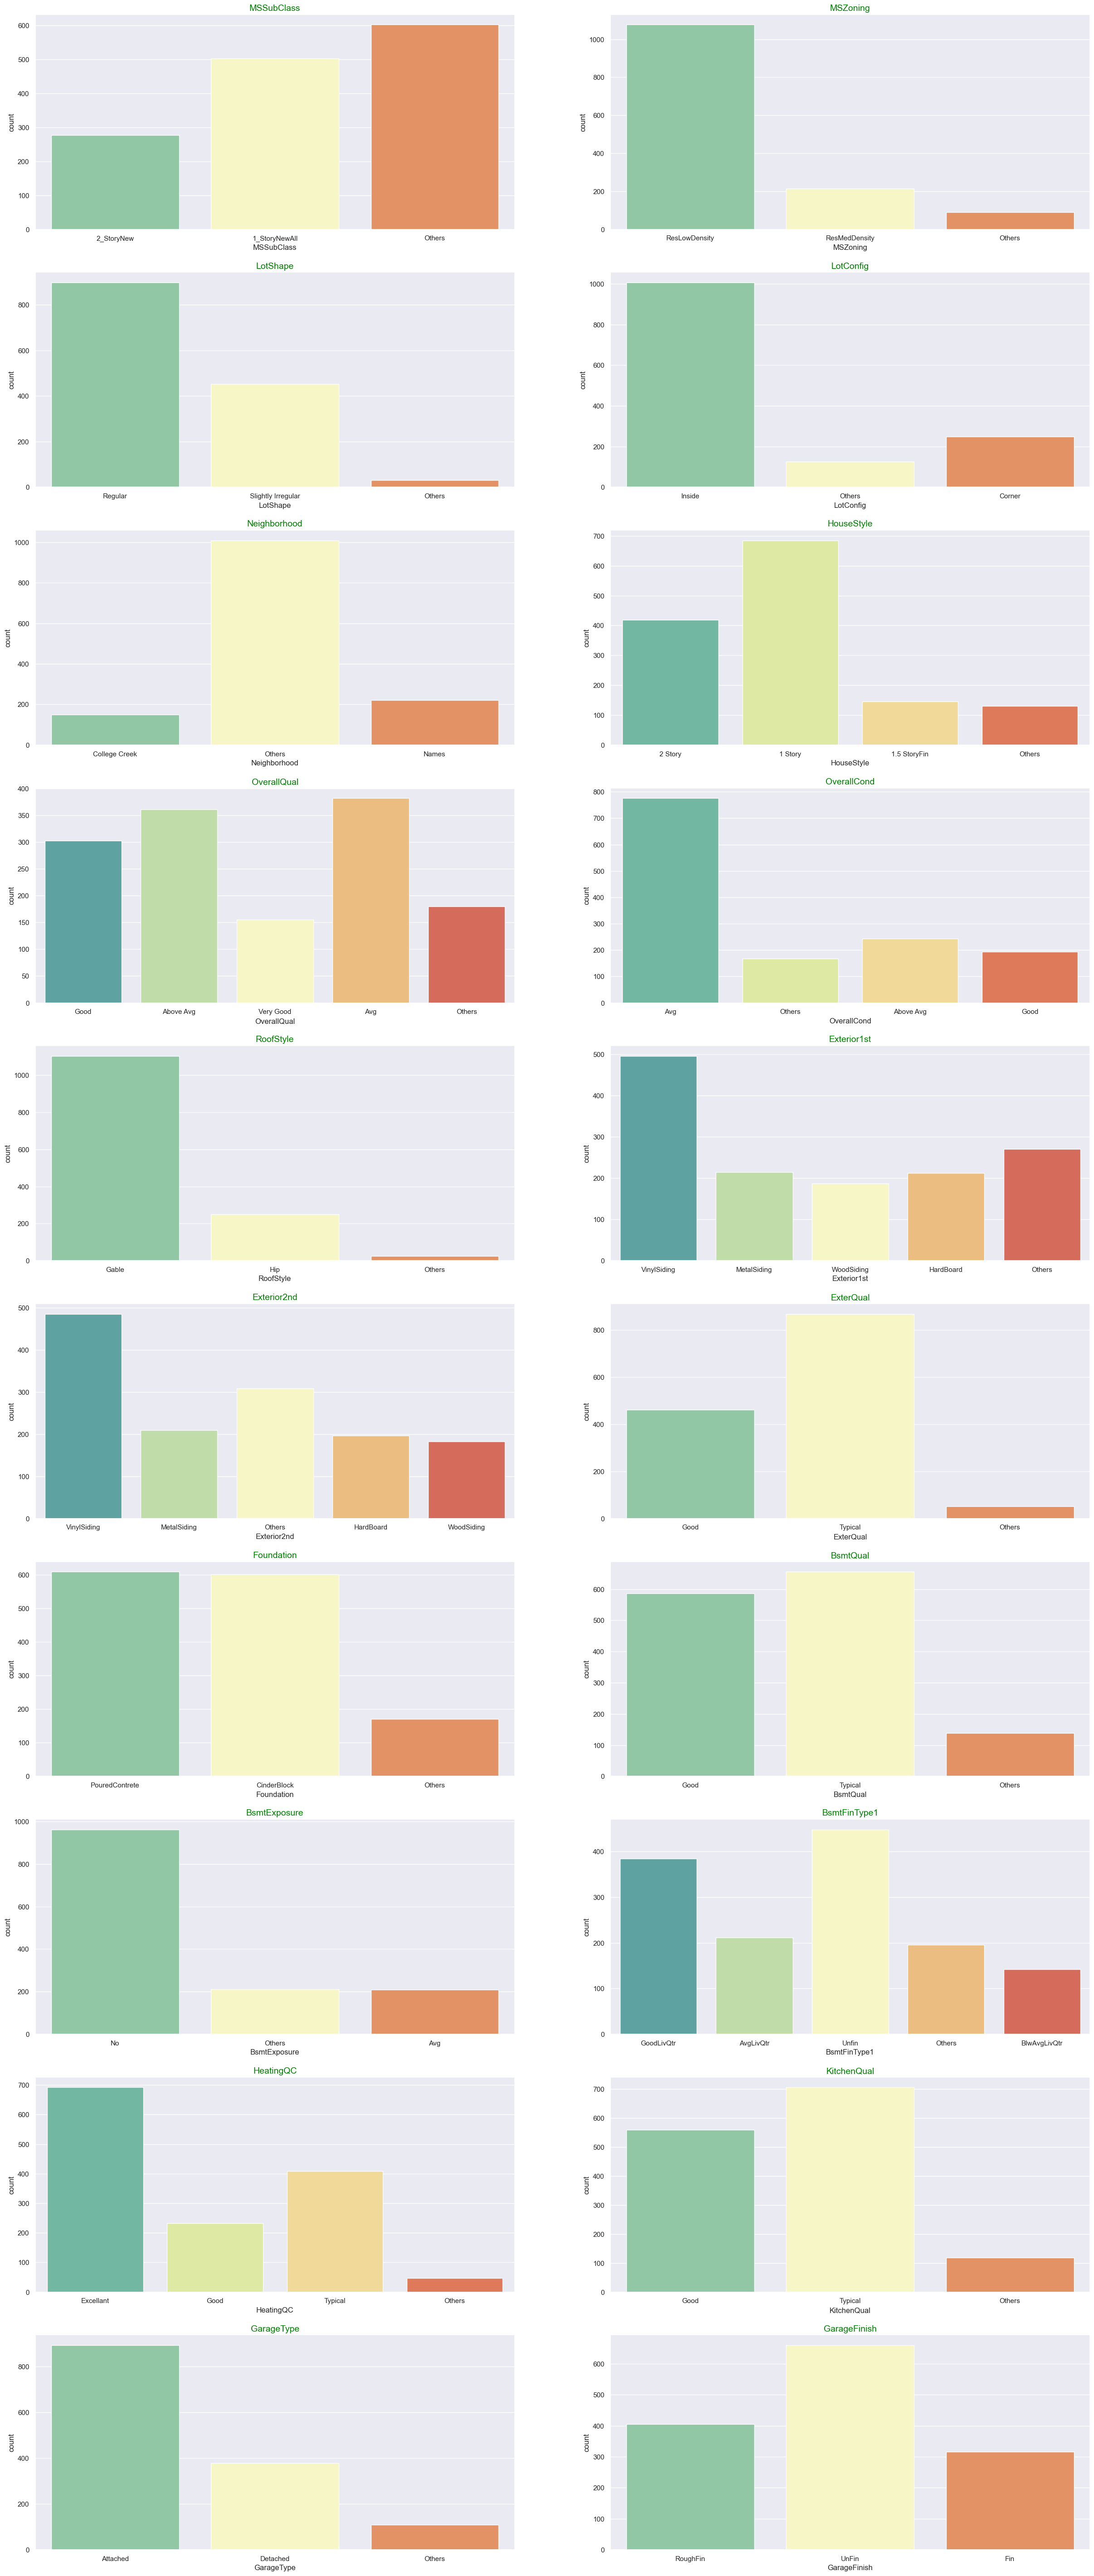

In [43]:
#bar chart - numerical vs categorical
p=1
plt.figure(figsize=(30,80))
for col in x_dict.keys():
    plt.subplot(11,2,p)
    sns.countplot(inp2, x=str(col), palette='Spectral_r')
    plt.title(str(col),fontdict={'fontsize':14,'fontweight':10,'color':'Green'})    
    p += 1
    
plt.show()

**Observations**<br>
1. Majority of sales were of type Others for MSSubClass with least for type 2_StoryNew.<br>
2. Majority of sales within the MSZoning is for properties with low density population while least for for all other types.<br>
3. Regular lot shape sizes are strongly preferable over all other types.<br>
4. Inside lot config is preferred strongly over all other types.<br>
5. Neighbourhoods besides College Creek & Names are very strongly preferred over all other types of neighbourhoods.<br>
6. 1 story house styles have higher demand in comparison with the remaining house styles.<br>
7. Majority of the properties sold either had a over quality of Average followred by Above Average followed closely by 
quality type Good.
8. However, overwhelming number of sales were for properties of overall condition of type Average.<br>
9. Overwhelming sales were for Gable type pf roof style.<br>
10. Vinyl siding was the most preferred option for the external covering of the house whether be it first or second coating.
Remaining types were on much lower scale and almost equivalent.<br>
11. As such, these properties with Vinyl siding were of typical quality. <br>
12. Purchasers did not distinguish demand between foundations consisting of poured concrete or cinder blocks. <br>
13. Basement quality tended to be more of Typical or Good quality.<br>
14. Majority of the properties did not have any exposure from the basement towards a garden or a walk out.<br>
15. There is clear demand for basements which are unfinished or having good living quarters.<br>
16. Clear demand for heating which are of Exellant quality.<br>
17. Kitchen too were of either Typical or Good quality.<br>
18. There is a clear demand for garages which are attached to the property.<br>
19. Majority of the properties sold had unfinished interior of the garages.<br>

**4.2 Relationship between the spread of the sales prices across the categories**

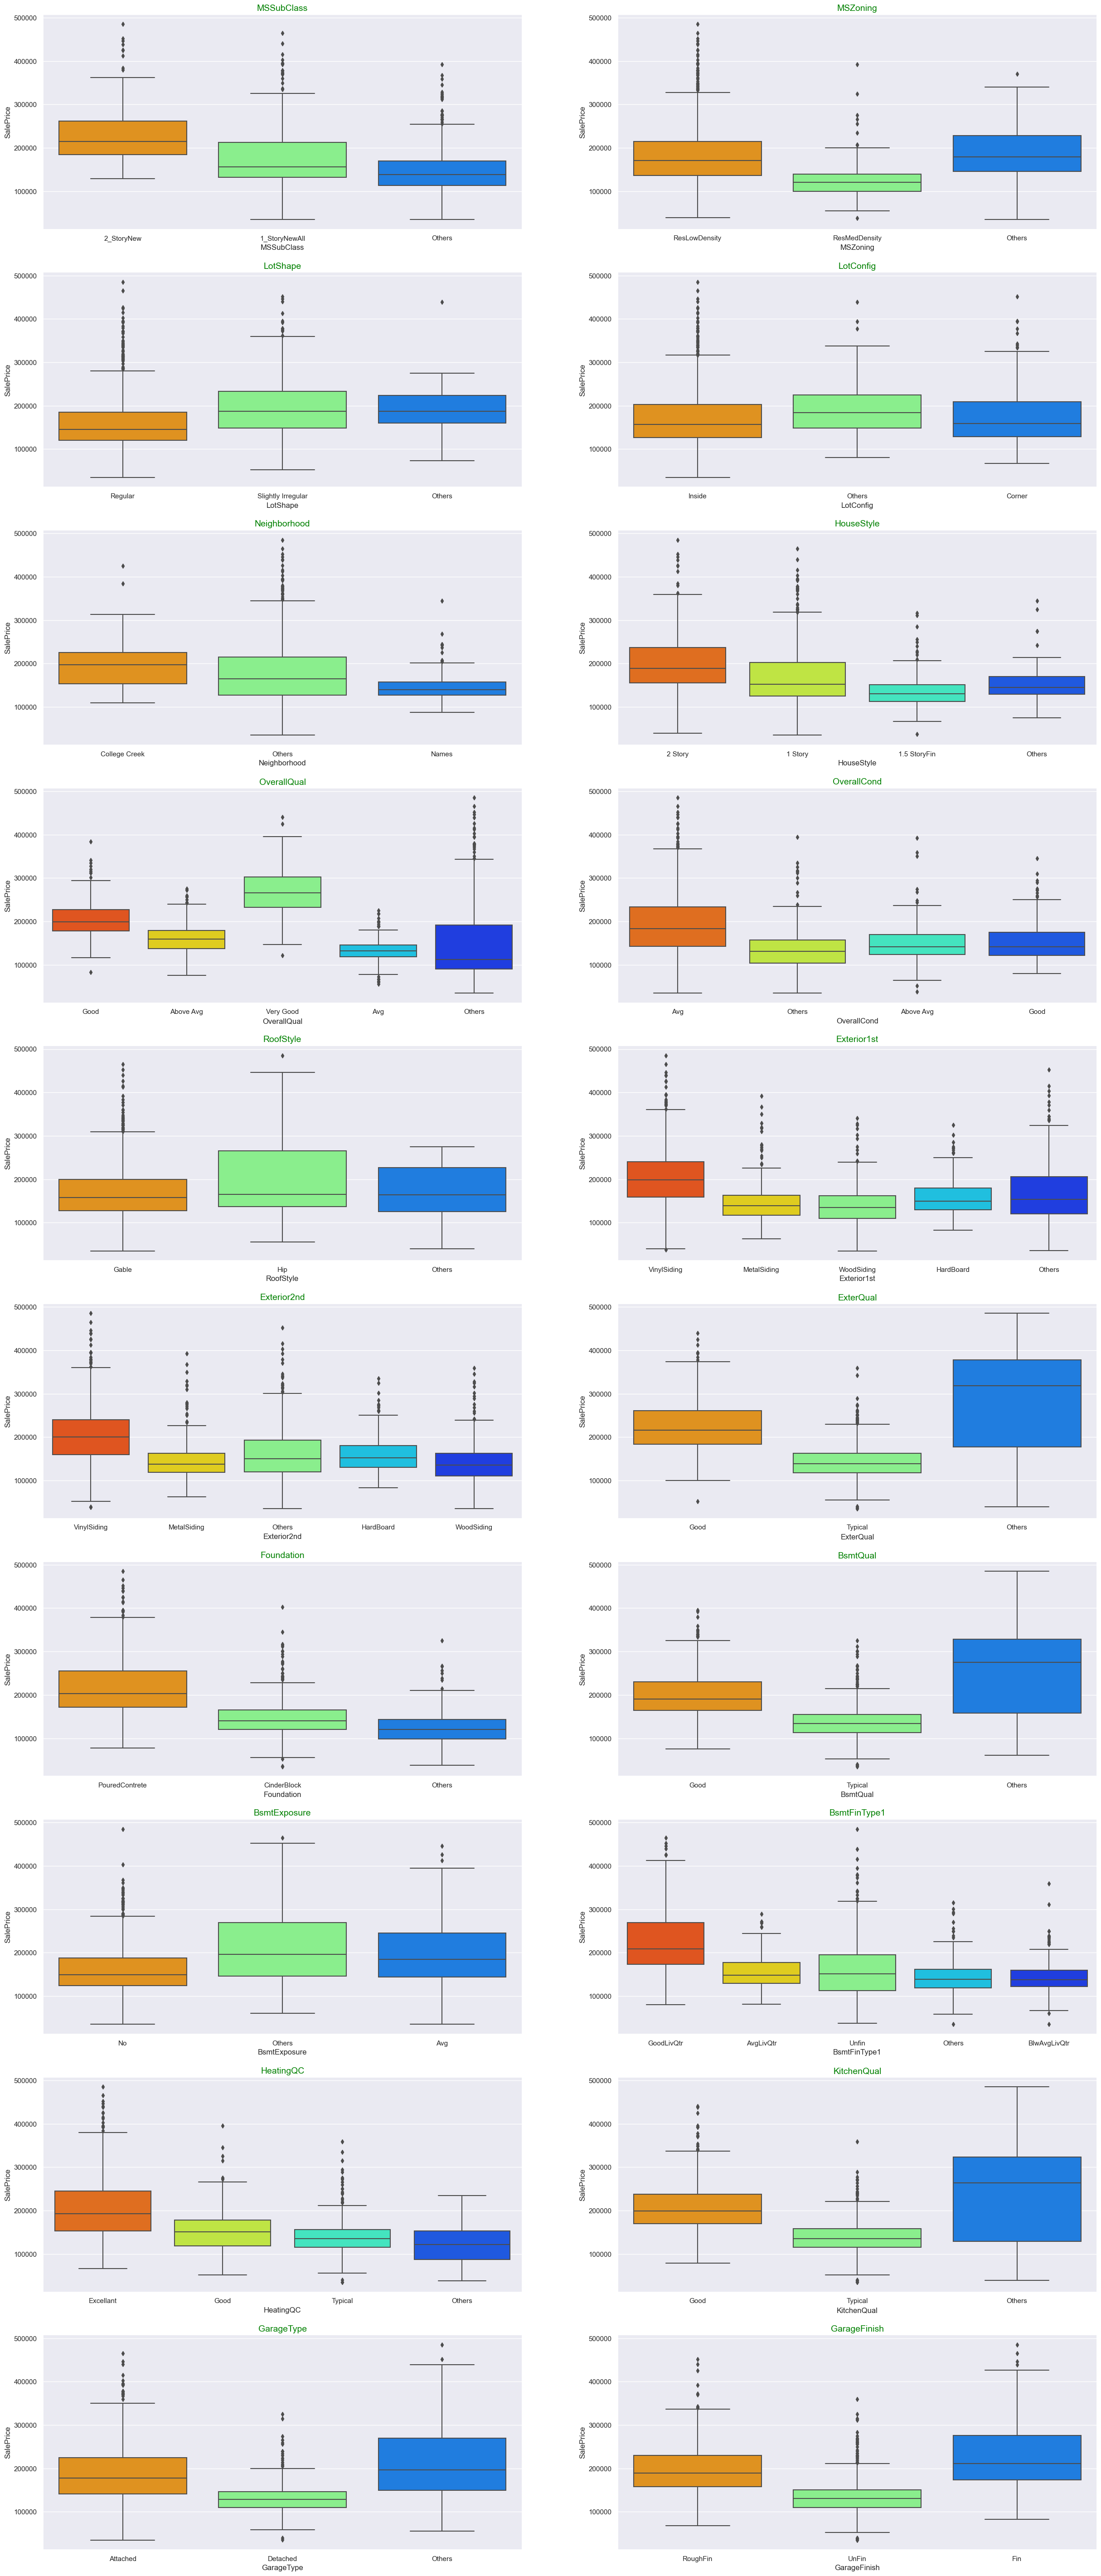

In [44]:
#boxplot - numerical vs categorical
p=1
fig=plt.figure(figsize=(30,80))
for col in x_dict.keys():
    plt.subplot(11,2,p)
    sns.boxplot(x=inp2[str(col)], y=inp2['SalePrice'], palette='jet_r')
    plt.title(str(col),fontdict={'fontsize':14,'fontweight':10,'color':'Green'})    
    p += 1

plt.show()

**Observations**<br>
*Average sales price in the range of 100k-400k:*<br>
1. 2 story properties which are new generally are sold in this range.<br>
2. Zones belong to low density or other residentials types are within this range.<br>
3. Slightly irregular properties have varied sales prices.<br>
4. All categories of lotconfig belong here.<br>
5. All categories of Neighbourhood lie here with Others having the vast range of values while Cottage Creek has higher 
sales price than the rest.<br>
6. House style of type 2 story has the highest cost overlapping on the lower end with 2 stories.<br>
7. Very good overall quality of the properties is in the upper end of this region which is highest among all types while 
Other types have a large variation of the sale price.<br>
8. Average overall condition of the properties has the highest and most varied variance of sales price.<br>
9. Hip roof style has the highest and most sales price variance among all its categories.<br>
10. Vinyl siding has the highest sales price.<br>
11. External quality for type Others is the highest with highest variance.<br>
12. Pourced Concrete has the highest cost among the rest.<br>
13. BsmtQual for type Others is highest and has highest variance.<br>
14. Sales price for BsmtExposure for types others & Avg have very similar spread.<br>
15. Good living quarters for basements have the highest sales price and much variation is its sales price. <br>
16. KitchenQual of type Others have the highest sales price with most variation.<br>
17. Garages which are attached have a lower sales price than those which are of Other types.<br>
18. Garages which are finished have the highest sales prices.<br>
19. HeatingQC which are excellant are quite expensive.<br>

**Overall Observations**<br>
*1. MSSubClass*<br>
Even though majority of the sales are for type Others, they had the least selling price while the demand for 2 story new 
properties maybe less but it is definitely more pricier than other property types.<br>
*2. MSZoning*<br>
High demand for low density residentials area are sold within 120k-210k.<br>
*3. LotShape*<br>
Regular lot shapes have high demand and have least sales prices compared to rest.<br>
*4. LotConfig*<br>
Sale prices are not affected by the LotConfig types.<br>
*5.Neighbourhood*<br>
While demand for type Others is high, it also has a wide range of sales price.<br>
*6. HouseStype*<br>
Demand for 1 story is very high, but its cost is almost similar to the 2 story on it's lower leg.<br>
*7. OverQual*<br>
Demand for Above average & average properties have much lower sales price compared to the property with Very Good quality.<br>
*8. OverCond*<br>
Demand for the average overall condition translates to highest sales price among its categories.<br>
*9. RoofStyle*<br>
Gable has the highest demand and is the one with the lowest sale price and its variance.<br>
*10. External1st & External2nd*<br>
Demand and cost of vinyl siding is very high compared to rest.<br>
*11. ExterQual*<br>
Demand for Typical type of external quality has the lowest sales price.<br>
*12. Foundation*<br>
Even though the demand for both poured concrete & cinder block are similar, the cost for poured concrete is much higher 
than cinder block.<br>
*13. BsmtQual*<br>
Demand for Typical and Good are similar but typical is the most expensive.<br>
*14. BsmtExposure*<br>
Properties with no basement exposure have the least cost.<br>
*15. BsmtFinType1*<br>
Unfinished has the highest demand and its cost is also less but the cost is spread more than the other types except for 
Good living quarters which has the highest cost and similar demand to Unfinished type.
*16. HeatingQC*<br>
Demand for Excellant quality is highest, however there is no discernable sales price difference between the various categories.<br>
*17. KitchenQual*<br>
Typical type have the highest demand and the least sales price, followed by Good type which has decent demand but higher 
sales price in comparision to Typical type.<br>
*18. GarageType*<br>
Attached type has highest demand but the sales price is much lower than the type with Others. <br>
*19. GarageFinish*<br>
Unfinished has the highest demand but the least sales price, while Finished has the least demand with the highest sales price.

**5. Plotting the dependent sales price feature**

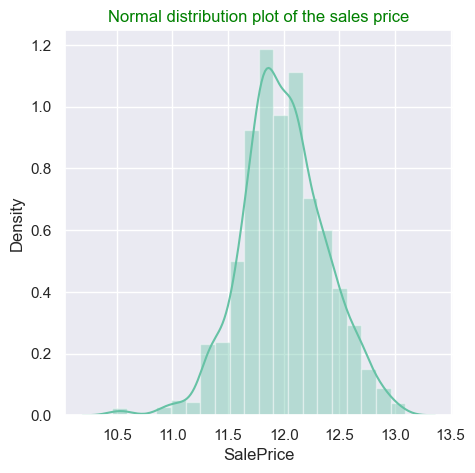

In [45]:
plt.figure(figsize=(5,5))
sns.distplot(np.log(inp2['SalePrice']), bins=20)
plt.title('Normal distribution plot of the sales price',fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.show()

**Observation**<br>
1. The sale price distribution plot is similar to normal distribution with noise affecting the data.<br>
2. The dependent feature SalePrice is linearly dependent on many independent features as noted above in EDA. Therefore, this
is a suitable case for multiple linear regression.

**6. Comparison of AgeBuiltYr, AgeRemodYr & AgeGarageYr with dependent variable**

**6.1 Determine relevance the age of the property since construction**

In [46]:
#find out on average years after construction are the properties purchased
inp2.pivot_table(index = 'MSZoning',columns='HouseStyle',values='AgeBuiltYr',aggfunc=np.mean)

HouseStyle,1 Story,1.5 StoryFin,2 Story,Others
MSZoning,,,,
Others,18.604815,91.834000,14.325741,63.000000
ResLowDensity,31.712280,68.470116,22.818094,38.831700
ResMedDensity,51.823030,76.556545,67.840606,62.154643


**Observation**<br>
On average, older houses that are sold are within the residential areas with medium density.

**6.2 Determine the average sales of the property for properties that are very old**

In [47]:
#find average sales price for properties that are above 50 years
inp2[inp2['AgeBuiltYr']>50].pivot_table(index = 'MSZoning',columns='HouseStyle',values='SalePrice',aggfunc=np.mean)

HouseStyle,1 Story,1.5 StoryFin,2 Story,Others
MSZoning,,,,
Others,57440.800000,104722.000000,123371.428571,104950.000000
ResLowDensity,126736.521429,139879.729730,181882.705882,145276.470588
ResMedDensity,104351.095238,122747.169811,131468.972222,131837.500000


**Observation**<br>
Residential areas with low density are sold at a higher cost when the age of property is high.

**6.3 Comparison over the years of the sales price**

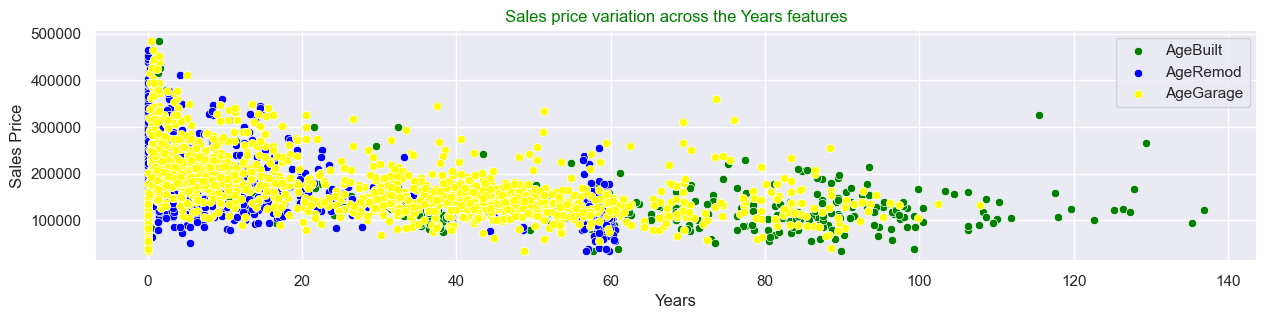

In [48]:
plt.figure(figsize=(15,3))
sns.scatterplot(inp2,x=inp2['AgeBuiltYr'],y= inp2['SalePrice'],color='green')
sns.scatterplot(inp2,x=inp2['AgeRemodYr'],y=inp2['SalePrice'],color='blue') 
sns.scatterplot(inp2,x=inp2['AgeGarageYr'],y=inp2['SalePrice'],color='yellow') 
plt.title('Sales price variation across the Years features' ,fontdict={'fontsize':12,'fontweight':5,'color':'Green'})      
plt.xlabel('Years')                               
plt.ylabel('Sales Price')  
plt.legend(['AgeBuilt','AgeRemod','AgeGarage'],loc='upper right')
plt.show()

**Observation**<br>
1. Costly properties are typically those where the properties do not have garage or have not been remodelled. <br>
2. This slightly tapers to properties with these features within 5 years.<br>
3. There are rare instances when properties whose construction age is above a century and is sold at a higher price but
never exceeding those properties that are newly constructed or those without which havent been remodelled or do not have 
garages.<br>
4. Major chuck of sales are towards the left middle of the plot.

**7. Comparison of total area square feet within a neigborhood & house style**

In [49]:
inp2.pivot_table(index='HouseStyle',columns='Neighborhood',values='GrLivArea',fill_value=0,aggfunc=np.mean)

Neighborhood,College Creek,Names,Others
HouseStyle,,,
1 Story,1289.560440,1196.872611,1306.931350
1.5 StoryFin,0.000000,1490.200000,1534.190840
2 Story,1873.773585,1922.380952,1822.028986
Others,902.500000,1287.965517,1326.916667


**Observation**<br>
On average, the maximum size of property within all neighborhoods is aove 1800 area square feet for 2 story properties.

**8. Find duplicated data within the data set**

In [50]:
inp2[inp2.duplicated()]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,KitchenQual,TotRmsAbvGrd,GarageType,GarageFinish,GarageCars,GarageArea,SalePrice,AgeBuiltYr,AgeRemodYr,AgeGarageYr


**Observation**<br>
There are no duplicate data within this dataset.

### IV. Data Preparation

**1. Create dummy variables for categorical values**

In [51]:
#copy into a new dataset
inp3 = inp2.copy()

#create variables
inp3_dummies = pd.get_dummies(inp3.select_dtypes(include='object'), drop_first=True)

#check if dummies are created correctly
inp3_dummies.head()

,MSSubClass_2_StoryNew,MSSubClass_Others,MSZoning_ResLowDensity,MSZoning_ResMedDensity,LotShape_Regular,LotShape_Slightly Irregular,LotConfig_Inside,LotConfig_Others,Neighborhood_Names,Neighborhood_Others,...,BsmtFinType1_Unfin,HeatingQC_Good,HeatingQC_Others,HeatingQC_Typical,KitchenQual_Others,KitchenQual_Typical,GarageType_Detached,GarageType_Others,GarageFinish_RoughFin,GarageFinish_UnFin
0,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0
2,1,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
4,1,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [52]:
#drop the categorical columns
inp3.drop(list(inp3.select_dtypes(include='object').columns),axis=1,inplace=True)

#add the dummies columns to the dataset
inp3 = pd.concat([inp3, inp3_dummies], axis=1)

#final shape of the dataset
inp3.shape

(1381, 67)

In [53]:
#list of columns in the dataset
print(list(inp3.columns))

['LotFrontage', 'LotArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice', 'AgeBuiltYr', 'AgeRemodYr', 'AgeGarageYr', 'MSSubClass_2_StoryNew', 'MSSubClass_Others', 'MSZoning_ResLowDensity', 'MSZoning_ResMedDensity', 'LotShape_Regular', 'LotShape_Slightly Irregular', 'LotConfig_Inside', 'LotConfig_Others', 'Neighborhood_Names', 'Neighborhood_Others', 'HouseStyle_1.5 StoryFin', 'HouseStyle_2 Story', 'HouseStyle_Others', 'OverallQual_Avg', 'OverallQual_Good', 'OverallQual_Others', 'OverallQual_Very Good', 'OverallCond_Avg', 'OverallCond_Good', 'OverallCond_Others', 'RoofStyle_Hip', 'RoofStyle_Others', 'Exterior1st_MetalSiding', 'Exterior1st_Others', 'Exterior1st_VinylSiding', 'Exterior1st_WoodSiding', 'Exterior2nd_MetalSiding', 'Exterior2nd_Others', 'Exterior2nd_VinylSiding', 'Exterior2nd_WoodSiding', 'ExterQual_Others', 'ExterQual_Typical', 'Foundation_Others', 'Foundation_PouredCont

**2. Divide dataset into train & test datasets**

In [54]:
# #divide dataset into train & test datasets in 70:30 ratio
np.random.seed(0)
inp3_train, inp3_test = train_test_split(inp3, train_size = 0.7, test_size = 0.3, random_state = 100)
print('Train dataset size =',inp3_train.shape)
print('Test dataset size =',inp3_test.shape)

Train dataset size = (966, 67)
Test dataset size = (415, 67)


**3. Perform scaling of continuous variables**<br>
Using Standard scaler to normalize the dtaa as much as possible for regularization.

In [55]:
scaler = StandardScaler()
num_vars = [i for i in inp3.select_dtypes(exclude='object').columns]
inp3_train[num_vars] = scaler.fit_transform(inp3_train[num_vars])
inp3_train.head()

,LotFrontage,LotArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,...,BsmtFinType1_Unfin,HeatingQC_Good,HeatingQC_Others,HeatingQC_Typical,KitchenQual_Others,KitchenQual_Typical,GarageType_Detached,GarageType_Others,GarageFinish_RoughFin,GarageFinish_UnFin
844,1.655402,1.034850,0.721067,-0.389197,-0.739167,-0.143763,-1.025002,1.458283,-0.203319,0.358517,...,1.451244,2.195285,-0.210533,-0.643699,-0.285914,0.991752,1.634932,-0.279508,-0.653363,1.046635
1074,0.296185,-0.215502,1.558807,0.539287,0.314337,-0.526116,0.812015,-1.075353,-0.203319,-0.931343,...,1.451244,-0.455522,-0.210533,-0.643699,-0.285914,-1.008316,-0.611646,-0.279508,1.530543,-0.955443
279,0.766684,0.225423,0.472507,0.335224,0.071220,1.172751,0.812015,1.458283,-0.203319,1.003447,...,-0.689064,-0.455522,-0.210533,-0.643699,-0.285914,0.991752,-0.611646,-0.279508,-0.653363,-0.955443
192,-0.017480,-0.075221,0.709560,1.026486,0.867137,-0.111176,0.812015,0.191465,-0.203319,-0.286413,...,-0.689064,-0.455522,-0.210533,-0.643699,-0.285914,-1.008316,-0.611646,-0.279508,-0.653363,-0.955443
106,-0.435700,0.467338,0.180218,-0.988631,-0.244252,-0.945402,-1.025002,-1.075353,-0.203319,-0.286413,...,1.451244,2.195285,-0.210533,-0.643699,-0.285914,0.991752,1.634932,-0.279508,-0.653363,1.046635


**4. Divide dataset features into dependent & independent variables**

In [56]:
#depedent variable = SalePrice
#indepdent variable = rest of features

y_train = inp3_train.pop('SalePrice')
X_train = inp3_train

### V. Model Building

**1. Multiple Linear Regression using Cross Validation using with/without VIF**

**1.1 Find the optimal value for hyper-parameter without VIF**

In [57]:
#create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 65))}]

#begin MLR
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm)             

# call GridSearchCV() to maximise hyper parameter
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)     

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [58]:
print(model_cv.best_params_)

{'n_features_to_select': 50}


In [59]:
# cv results to see the ranks of each hyper parameter
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.282130,0.016012,0.004049,0.002356,1,{'n_features_to_select': 1},0.570034,0.485685,0.438171,0.398711,...,0.468575,0.057839,64,0.448273,0.470070,0.480538,0.492102,0.478592,0.473915,0.014620
1,0.292023,0.024710,0.009491,0.006672,2,{'n_features_to_select': 2},0.689117,0.688798,0.709258,0.639169,...,0.675681,0.025965,63,0.675395,0.676154,0.671846,0.688827,0.685089,0.679462,0.006401
2,0.209818,0.037633,0.003123,0.006246,3,{'n_features_to_select': 3},0.760495,0.734409,0.755976,0.730881,...,0.748379,0.012992,62,0.748514,0.756024,0.750320,0.756831,0.748764,0.752090,0.003604
3,0.152765,0.013856,0.006754,0.008278,4,{'n_features_to_select': 4},0.764965,0.752543,0.767595,0.758893,...,0.764375,0.008521,61,0.768365,0.772441,0.768251,0.770696,0.773359,0.770622,0.002075
4,0.172475,0.026756,0.005625,0.005338,5,{'n_features_to_select': 5},0.795901,0.772585,0.787980,0.782025,...,0.783765,0.007808,60,0.789249,0.795863,0.791452,0.793195,0.799505,0.793853,0.003560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.050615,0.003048,0.004891,0.001918,60,{'n_features_to_select': 60},0.877618,0.860398,0.857356,0.866678,...,0.863340,0.008185,18,0.882458,0.886787,0.886822,0.885773,0.886716,0.885711,0.001672
60,0.043861,0.004881,0.004888,0.000882,61,{'n_features_to_select': 61},0.877675,0.860227,0.857793,0.866430,...,0.863366,0.008125,16,0.882461,0.886818,0.886833,0.885793,0.886727,0.885726,0.001678
61,0.040084,0.006070,0.005076,0.001491,62,{'n_features_to_select': 62},0.877731,0.860009,0.857919,0.866459,...,0.863361,0.008151,17,0.882466,0.886844,0.886838,0.885801,0.886737,0.885737,0.001682
62,0.042514,0.012990,0.008134,0.003755,63,{'n_features_to_select': 63},0.877647,0.859921,0.857929,0.866436,...,0.863287,0.008165,19,0.882470,0.886848,0.886843,0.885802,0.886741,0.885741,0.001682


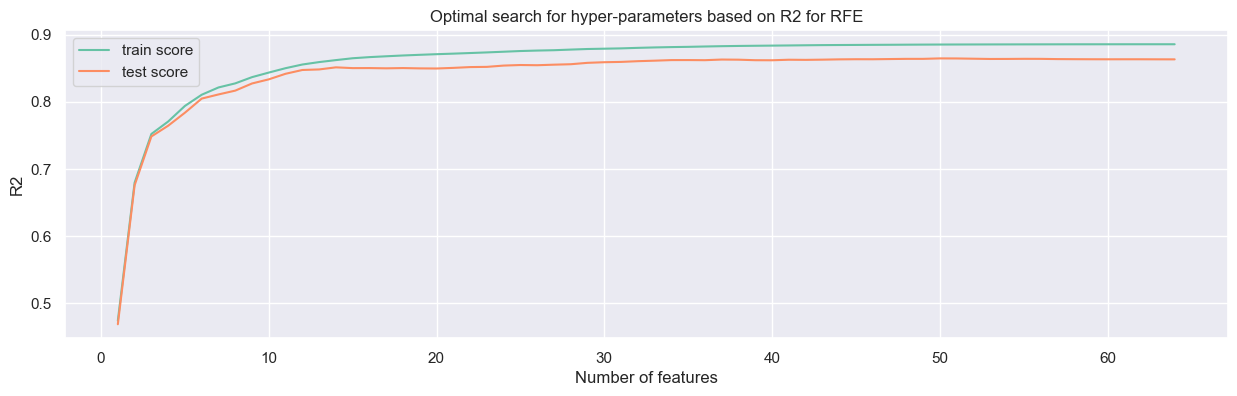

In [60]:
#plot results for different alphas
plt.figure(figsize=(15,4))
plt.plot(cv_results['param_n_features_to_select'], cv_results['mean_train_score'])
plt.plot(cv_results['param_n_features_to_select'], cv_results['mean_test_score'])
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title("Optimal search for hyper-parameters based on R2 for RFE")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

**1.2 Build the final MLR model without VIF**

In [61]:
#retrieve the optimal value 
print(list(model_cv.best_params_.values())[0])

50


In [62]:
# plugging in optimal RFE to find relevant features
lm = LinearRegression()
lm.fit(X_train, y_train)

#RFE
rfe = RFE(lm, n_features_to_select=list(model_cv.best_params_.values())[0])             
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 10),
 ('LotArea', True, 1),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', False, 2),
 ('GrLivArea', True, 1),
 ('FullBath', True, 1),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', True, 1),
 ('GarageCars', True, 1),
 ('GarageArea', True, 1),
 ('AgeBuiltYr', True, 1),
 ('AgeRemodYr', True, 1),
 ('AgeGarageYr', True, 1),
 ('MSSubClass_2_StoryNew', True, 1),
 ('MSSubClass_Others', True, 1),
 ('MSZoning_ResLowDensity', False, 3),
 ('MSZoning_ResMedDensity', True, 1),
 ('LotShape_Regular', True, 1),
 ('LotShape_Slightly Irregular', True, 1),
 ('LotConfig_Inside', False, 15),
 ('LotConfig_Others', False, 9),
 ('Neighborhood_Names', True, 1),
 ('Neighborhood_Others', False, 6),
 ('HouseStyle_1.5 StoryFin', True, 1),
 ('HouseStyle_2 Story', True, 1),
 ('HouseStyle_Others', True, 1),
 ('OverallQual_Avg', False, 13),
 ('OverallQual_Good', True, 1),
 ('OverallQual_Others', True, 1),
 ('OverallQual_Very Good', True, 1),
 ('Ove

In [63]:
col_drop=[]
col_drop = X_train.columns[~rfe.support_]
X_train.drop(col_drop, axis=1, inplace=True)
X_train.shape

(966, 50)

In [64]:
#final MLR model
lm = LinearRegression()
lm.fit(X_train, y_train)

#intercept, coefficient
print(lm.intercept_)
print(lm.coef_)

-2.316671632574048e-16
[ 0.06039961 -0.1161862   0.28939599  0.34557038  0.03891409 -0.06224209
 -0.08287411  0.035874    0.08716565  0.04496503 -0.19143636 -0.03653249
  0.02670263 -0.03261918 -0.03663632 -0.05142062  0.0253688   0.0317417
 -0.01772324  0.01424733  0.08981216  0.03558535  0.01479841  0.02817854
  0.11916532 -0.07842464  0.03588243 -0.03937605 -0.10382161 -0.05211132
  0.10977401  0.0729937   0.0945535  -0.0250644   0.05726368  0.0749327
  0.08774826  0.06657693 -0.01863829  0.0320794   0.05106671 -0.02760159
  0.03353132 -0.01396263 -0.02868102 -0.03632388  0.04931652 -0.01859091
 -0.02159292 -0.02317678]


In [65]:
#build final table with constants & all coefficients
model = pd.DataFrame()
y_list = []
y_list = [lm.intercept_]
y_list.extend(lm.coef_)
model['MLR'] = y_list

**1.3 Predict both the train and test datasets using the MLR model without VIF**

In [66]:
#scale numerical features of the test dataset
inp3_test[num_vars] = scaler.fit_transform(inp3_test[num_vars])

#split into y and X
y_test = inp3_test.pop('SalePrice')
X_test= inp3_test
X_test.drop(col_drop, axis=1, inplace=True)

# predict 
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

**1.4 Check the assumptions of Linear Regression**

**1.4.1 Check whether error terms are normally distributed**

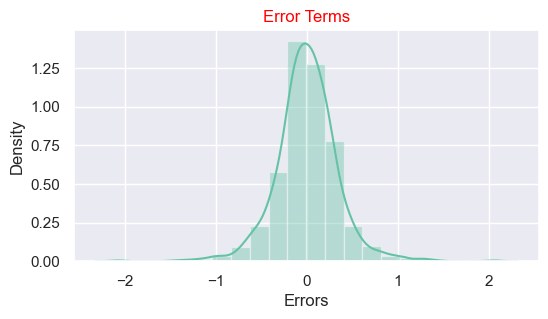

In [67]:
#normality check of residuals
# Plot the histogram of the error terms to confirm linear regression rules
plt.figure(figsize=(6,3))
sns.distplot((y_train - y_train_pred), bins = 20)
plt.title('Error Terms' , fontdict={'fontsize':12,'fontweight':10,'color':'Red'} )                
plt.xlabel('Errors')  
plt.show()

**Observation**<br>
1. Error terms are normally distributed.<br>
2. Mean of the error terms are hovering around 0.<br>
3. Requirements for linear regression for errors terms of the expected model are met.

**1.4.2 Patterns in the residuals wrt fitted feature count**

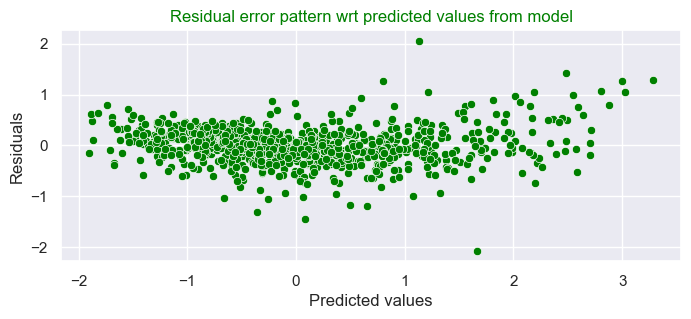

In [68]:
# Patterns in the residuals wrt fitted feature count
plt.figure(figsize=(8,3))
plt.title('Residual error pattern wrt predicted values from model',fontdict={'fontsize':12,'fontweight':5,'color':'Green'})
sns.scatterplot(x=y_train_pred, y=(y_train-y_train_pred), color='Green')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

**Observation**<br>
There is no visible pattern when plotting the residuals(errors) against the predicted values(total predicted demand) from 
the train dataset.

**1.4.3 Error terms have constants variance (homoscedastiticy)**

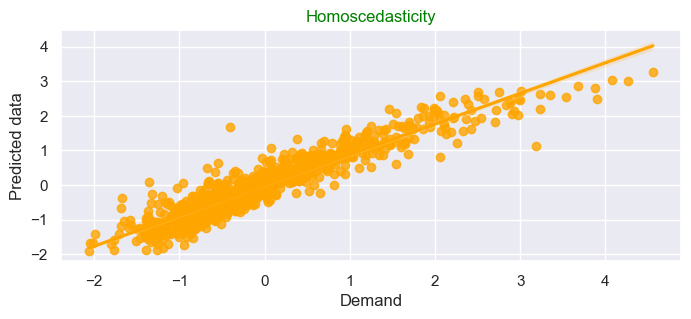

In [69]:
plt.figure(figsize=(8,3))
plt.title('Homoscedasticity',fontdict={'fontsize':12,'fontweight':5,'color':'Green'})
sns.regplot(x=y_train, y=y_train_pred, color='Orange')
plt.xlabel('Demand')
plt.ylabel('Predicted data')
plt.show()

**Observation**<br>
Residuals(errors) from the final model has homoscedasticity properties. Therefore all the assumptions regarding Linear regression for this model have been satisfied.<br>
Also, this also proves that polynomial regression or data transformation is not required.

**1.5 Plot of actual & predicted values of training data set**

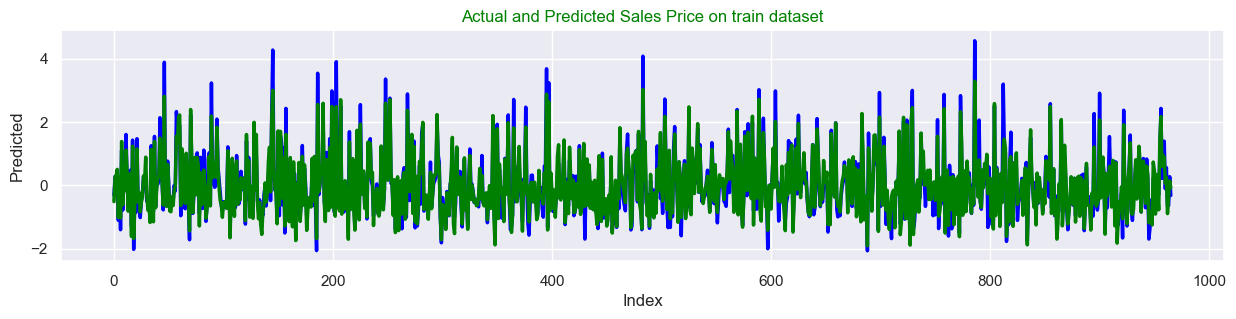

In [70]:
#Actual vs Predicted
c = [i for i in range(0,len(X_train),1)]
plt.figure(figsize=(15,3))
plt.plot(c,y_train, color="blue", linewidth=2.5, linestyle="-") #actual values
plt.plot(c,y_train_pred, color="green",  linewidth=2.5, linestyle="-") #predicted values
plt.title('Actual and Predicted Sales Price on train dataset' ,
            fontdict={'fontsize':12,'fontweight':5,'color':'Green'})      
plt.xlabel('Index')                               
plt.ylabel('Predicted')    
plt.show()

**Observation**<br>
Actual & predicated values are almost similar.

**1.4 Find optimal value of hyper-parameter for MLR model with VIF**

In [71]:
#calculate VIF to compare across all models
vif = pd.DataFrame()
X = X_train
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
30,Exterior2nd_VinylSiding,22.28
28,Exterior1st_VinylSiding,22.17
16,LotShape_Regular,13.47
17,LotShape_Slightly Irregular,13.07
3,GrLivArea,6.73
10,AgeBuiltYr,6.65
8,GarageCars,6.00
20,HouseStyle_2 Story,5.99
9,GarageArea,5.60
2,TotalBsmtSF,5.10


In [72]:
X_train_vif = X_train.copy()

#below values have high correlation with each other(independent features) or are not closely related to the dependent 
#variable therefore drop them;multicollinearity
X_train_vif.drop(['Exterior1st_VinylSiding','FullBath', 'AgeRemodYr','TotRmsAbvGrd','GarageArea','AgeGarageYr',
                  'BedroomAbvGr','HeatingQC_Others'],
                 axis=1,inplace=True)

In [73]:
#confirm
X_train_vif.shape

(966, 42)

Preference is to have a model with less number of features, so let us restrict the optimal search upto 15 features & find
the best among them. In conjection with VIF, this model will bring a variation to the previous model by using both 
automatic & manual tuning of hyper-parameters.

In [74]:
# create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters to tune of upto max 15 features
hyper_params = [{'n_features_to_select': list(range(1, 15))}]


lm = LinearRegression()
lm.fit(X_train_vif, y_train)

rfe = RFE(lm)             

# call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_vif, y_train)     
print(model_cv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'n_features_to_select': 14}


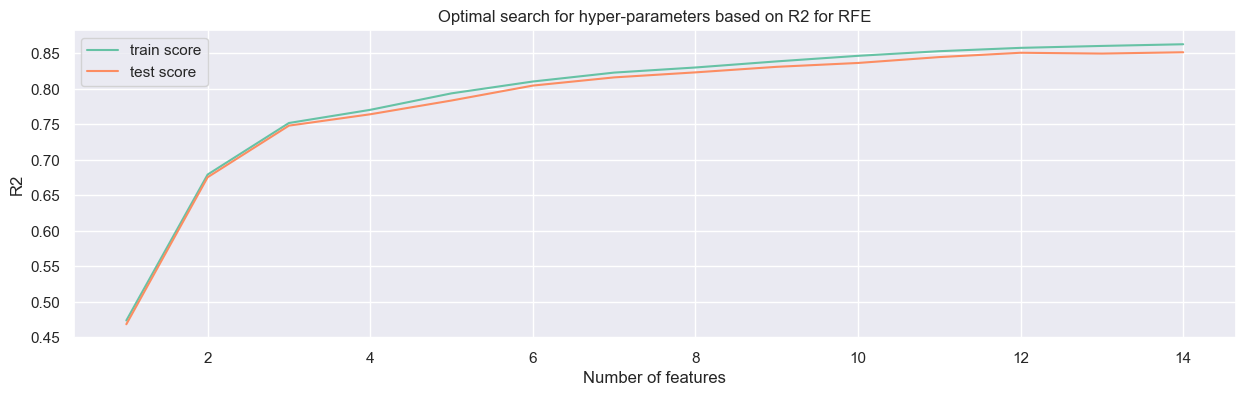

In [75]:
#plot results for different alphas
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(15,4))
plt.plot(cv_results['param_n_features_to_select'], cv_results['mean_train_score'])
plt.plot(cv_results['param_n_features_to_select'], cv_results['mean_test_score'])
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title("Optimal search for hyper-parameters based on R2 for RFE")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

**1.5 Build final MLR with VIF**

In [76]:
#plug in the optimal value of hyper-parameter
lm = LinearRegression()
lm.fit(X_train_vif, y_train)

#RFE
rfe = RFE(lm, n_features_to_select=list(model_cv.best_params_.values())[0])             
rfe = rfe.fit(X_train_vif, y_train)
list(zip(X_train_vif.columns,rfe.support_,rfe.ranking_))

[('LotArea', True, 1),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('GrLivArea', True, 1),
 ('KitchenAbvGr', True, 1),
 ('GarageCars', True, 1),
 ('AgeBuiltYr', True, 1),
 ('MSSubClass_2_StoryNew', False, 17),
 ('MSSubClass_Others', False, 16),
 ('MSZoning_ResMedDensity', False, 7),
 ('LotShape_Regular', False, 21),
 ('LotShape_Slightly Irregular', False, 20),
 ('Neighborhood_Names', False, 23),
 ('HouseStyle_1.5 StoryFin', False, 29),
 ('HouseStyle_2 Story', False, 8),
 ('HouseStyle_Others', False, 15),
 ('OverallQual_Good', False, 26),
 ('OverallQual_Others', False, 18),
 ('OverallQual_Very Good', True, 1),
 ('OverallCond_Avg', True, 1),
 ('OverallCond_Good', False, 3),
 ('OverallCond_Others', False, 12),
 ('Exterior1st_WoodSiding', False, 10),
 ('Exterior2nd_VinylSiding', False, 27),
 ('Exterior2nd_WoodSiding', False, 9),
 ('ExterQual_Others', True, 1),
 ('ExterQual_Typical', False, 4),
 ('Foundation_Others', False, 6),
 ('Foundation_PouredContrete', True, 1),
 ('BsmtQual_O

In [77]:
#rejected features from RFE tuning
print(list(X_train_vif.columns[~rfe.support_]))

['MSSubClass_2_StoryNew', 'MSSubClass_Others', 'MSZoning_ResMedDensity', 'LotShape_Regular', 'LotShape_Slightly Irregular', 'Neighborhood_Names', 'HouseStyle_1.5 StoryFin', 'HouseStyle_2 Story', 'HouseStyle_Others', 'OverallQual_Good', 'OverallQual_Others', 'OverallCond_Good', 'OverallCond_Others', 'Exterior1st_WoodSiding', 'Exterior2nd_VinylSiding', 'Exterior2nd_WoodSiding', 'ExterQual_Typical', 'Foundation_Others', 'BsmtQual_Typical', 'BsmtExposure_No', 'BsmtExposure_Others', 'BsmtFinType1_Others', 'BsmtFinType1_Unfin', 'HeatingQC_Good', 'HeatingQC_Typical', 'KitchenQual_Typical', 'GarageFinish_RoughFin', 'GarageFinish_UnFin']


In [78]:
col_drop=[]
col_drop = X_train_vif.columns[~rfe.support_]
X_train_vif.drop(col_drop, axis=1, inplace=True)
X_train_vif.shape

(966, 14)

Ideally, determining a MLR model is a combination of manual and automatic repetitive process which is time-consuming in
context of this assignment. Therefore, we assume at the point, that this is the best model that can be achieved given
the time-constriant & complexity of this assignment with the goal being to compare different models & their metrics.

In [79]:
# final MLR model
lm = LinearRegression()
lm.fit(X_train_vif, y_train)

print(lm.intercept_)
print(lm.coef_)

-2.2420224219854027e-16
[ 0.08609208 -0.09191171  0.2317149   0.40086505 -0.09119247  0.13992546
 -0.23376436  0.12680559 -0.09963635  0.10264181  0.09339036  0.09571126
  0.06292116  0.06194334]


**1.6 Predict train & test using final MLR with VIF**

In [80]:
X_test_vif= inp3_test[X_train_vif.columns]

# predict 
y_train_vif_pred = lm.predict(X_train_vif)
y_test_vif_pred = lm.predict(X_test_vif)

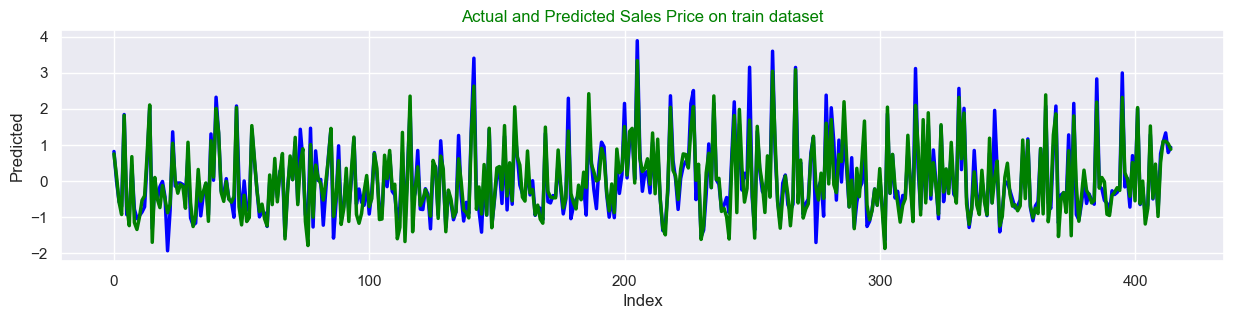

In [81]:
#Actual vs Predicted
c = [i for i in range(0,len(X_test),1)]
plt.figure(figsize=(15,3))
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #actual values
plt.plot(c,y_test_pred, color="green",  linewidth=2.5, linestyle="-") #predicted values
plt.title('Actual and Predicted Sales Price on train dataset' ,
            fontdict={'fontsize':12,'fontweight':5,'color':'Green'})      
plt.xlabel('Index')                               
plt.ylabel('Predicted')    
plt.show()

**1.6 Calculation of statistic metrics** 

In [82]:
#create function call to be executed after each model execution
def calc_metrics(model,a_actual,a_pred):
    z_list=[]
    z_list.append(str(model))
    z_list.append(round(r2_score(a_actual, a_pred),4))
    z_list.append(round(np.sum(np.square(a_actual - a_pred)),4))
    z_list.append(round(mean_squared_error(a_actual, a_pred)**0.5,4))
    z_list.append(round((1 - (1 - r2_score(a_actual, a_pred)) * ((X_train.shape[0] - 1) / 
                                                                 (X_train.shape[0] - X_train.shape[1] - 1))),4))
    return z_list

In [83]:
metric=[]
metric.append(calc_metrics('MLR[Train]',y_train,y_train_pred))
metric.append(calc_metrics('MLR[Test]',y_test,y_test_pred))
metric.append(calc_metrics('MLR-VIF[Train]',y_train,y_train_vif_pred))
metric.append(calc_metrics('MLR-VIF[Test]',y_test,y_test_vif_pred))

In [84]:
#build final table with constants & all coefficients
model_vif=pd.DataFrame()
y_list = []
y_list = [lm.intercept_]
y_list.extend(lm.coef_)
model_vif['MLR'] = y_list

**2. Ridge Regularization with/without VIF**<br>
Let us see if applying Ridge regularization to check if the statistics metrics improve.

**2.1 Find the optimal value for hyper-parameter for model without VIF**

In [85]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# # it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                    4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [86]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 50}


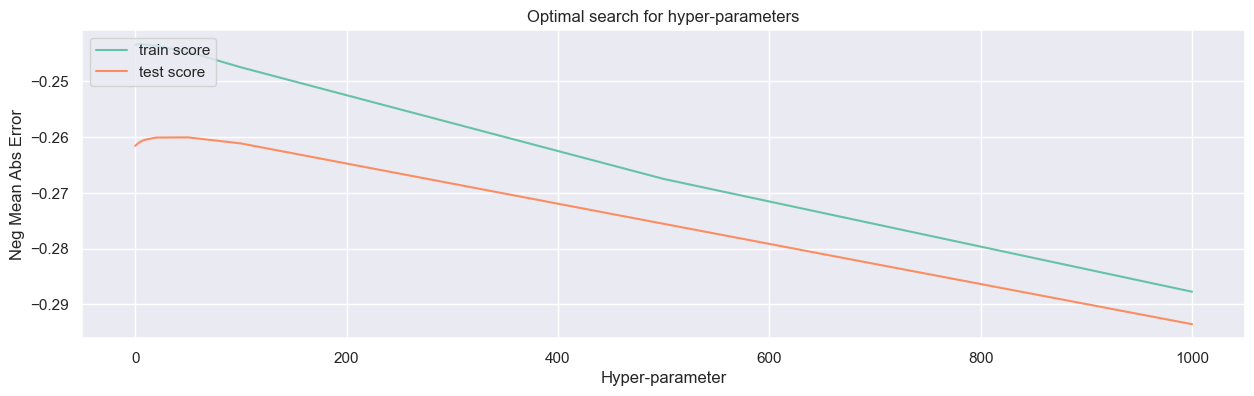

In [87]:
#plot results for different alphas
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(15,4))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('Hyper-parameter')
plt.ylabel('Neg Mean Abs Error')
plt.title("Optimal search for hyper-parameters")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

**2.2 Build final Ridge model using optimal alpha without VIF & predict**

In [88]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
ridge = Ridge(alpha=list(model_cv.best_params_.values())[0])

ridge.fit(X_train, y_train)
print(ridge.intercept_)
print(ridge.coef_)

-2.2833754366799286e-16
[ 0.06424728 -0.08015587  0.24387504  0.29690442  0.04629382 -0.05009055
 -0.08153841  0.05826339  0.08433923  0.06297786 -0.13959732 -0.04101154
  0.01740418 -0.00853303 -0.02940633 -0.0474951   0.00952863  0.0173343
 -0.01730936  0.00746061  0.06021879  0.02375797  0.01292083  0.02309524
  0.11598285 -0.06676218  0.03278435 -0.03912726 -0.0306994  -0.03856662
  0.03108208  0.05875912  0.08900252 -0.03446579  0.03992106  0.06348936
  0.08665073  0.04101799 -0.02045479  0.03463741  0.05293277 -0.02831557
  0.00640193 -0.02018762 -0.02888667 -0.03986494  0.05560347 -0.02263691
 -0.02112389 -0.03112442]


In [89]:
#predict
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [90]:
#build final table with constants & all coefficients
y_list = []
y_list = [ridge.intercept_]
y_list.extend(ridge.coef_)
model['Ridge'] = y_list

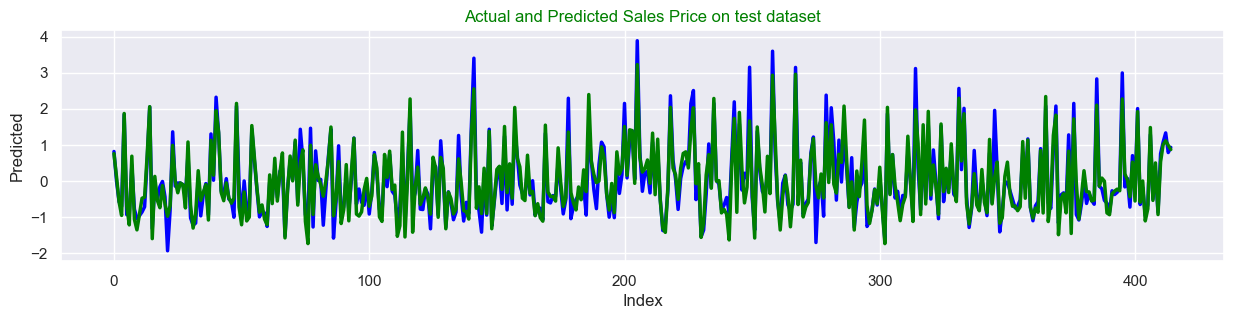

In [91]:
#Actual vs Predicted
c = [i for i in range(0,len(X_test),1)]
plt.figure(figsize=(15,3))
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #actual values
plt.plot(c,y_test_pred, color="green",  linewidth=2.5, linestyle="-") #predicted values
plt.title('Actual and Predicted Sales Price on test dataset' ,
            fontdict={'fontsize':12,'fontweight':5,'color':'Green'})      
plt.xlabel('Index')                               
plt.ylabel('Predicted')    
plt.show()

**2.3 Find optimal value for hyper parameter using VIF**

In [92]:
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_vif, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [93]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 50}


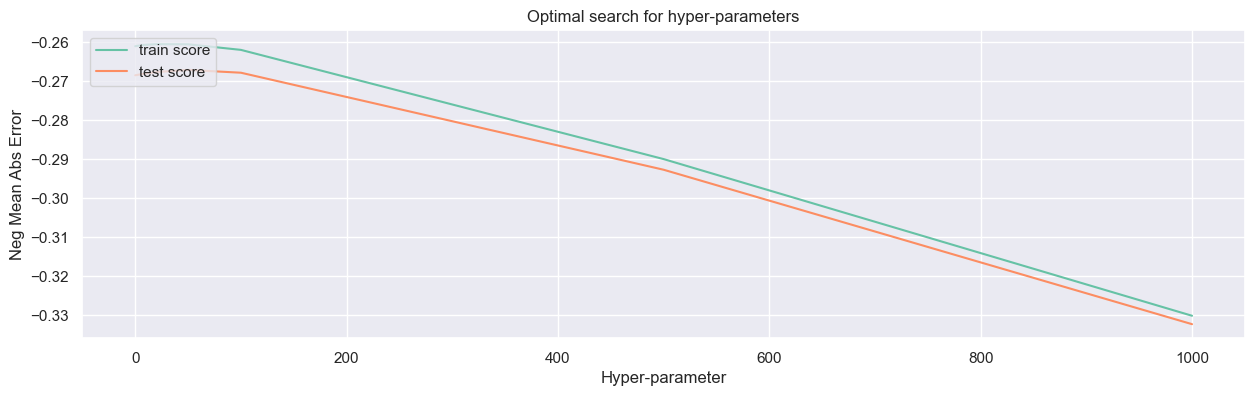

In [94]:
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(15,4))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('Hyper-parameter')
plt.ylabel('Neg Mean Abs Error')
plt.title("Optimal search for hyper-parameters")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

**2.4 Build final model with VIF**

In [95]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
ridge = Ridge(alpha=list(model_cv.best_params_.values())[0])

ridge.fit(X_train_vif, y_train)
print(ridge.intercept_)
print(ridge.coef_)

-2.248212005900184e-16
[ 0.09342323 -0.07547342  0.21832599  0.37538459 -0.08786779  0.14683254
 -0.21261269  0.12609824 -0.08282055  0.09975914  0.09395225  0.09443624
  0.07250593  0.06334528]


**2.5 Predict using final model without VIF & calculate metrics**

In [96]:
# # Lets calculate some metrics such as R2 score, RSS and RMSE
y_train_vif_pred = ridge.predict(X_train_vif)
y_test_vif_pred = ridge.predict(X_test_vif)

metric.append(calc_metrics('Ridge[Train]',y_train,y_train_pred))
metric.append(calc_metrics('Ridge[Test]',y_test,y_test_pred))
metric.append(calc_metrics('Ridge-VIF[Train]',y_train,y_train_vif_pred))
metric.append(calc_metrics('Ridge-VIF[Test]',y_test,y_test_vif_pred))

In [97]:
#build final table with constants & all coefficients
y_list = []
y_list = [ridge.intercept_]
y_list.extend(ridge.coef_)
model_vif['Ridge'] = y_list

**3. Lasso Regularization with/without VIF**

**3.1 Find optimal value of hyper-parameter without using VIF**

In [98]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [99]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.01}


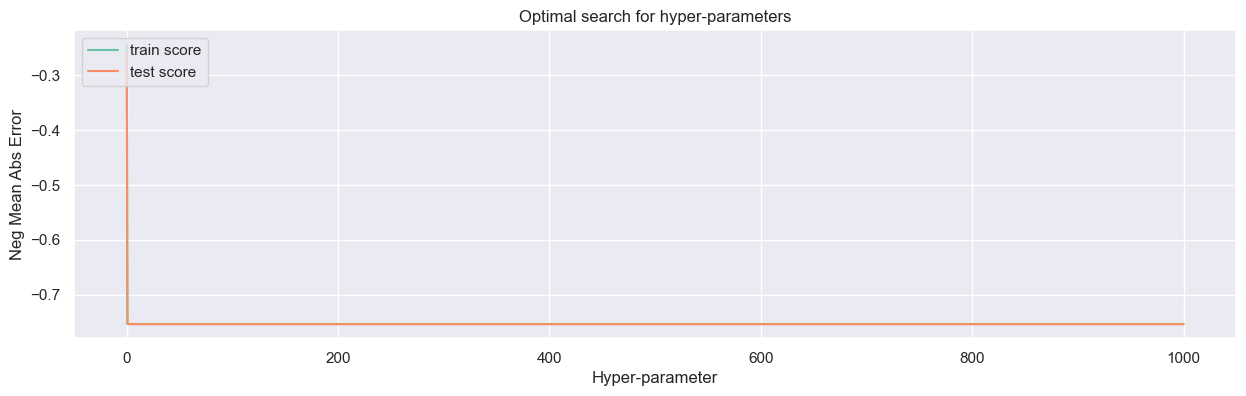

In [100]:
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(15,4))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('Hyper-parameter')
plt.ylabel('Neg Mean Abs Error')
plt.title("Optimal search for hyper-parameters")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

**3.2 Build final model without VIF & predict**

In [101]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised
lasso = Lasso(alpha=list(model_cv.best_params_.values())[0])
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.01)

In [102]:
print(lasso.intercept_)
print(lasso.coef_)

-2.3897798648422e-16
[ 0.05673643 -0.07155358  0.21979388  0.38699876  0.01717248 -0.02255885
 -0.07709997  0.00625841  0.09268135  0.04874208 -0.15041457 -0.026932
  0.          0.         -0.01559455 -0.03614076 -0.          0.00485971
 -0.0033649  -0.00291742  0.00978842  0.          0.          0.01299347
  0.10535565 -0.0552618   0.03172475 -0.02699649  0.         -0.
  0.          0.01425202  0.09006982 -0.03133941  0.01844876  0.05213449
  0.08245519  0.00076241 -0.02160702  0.02297769  0.04907685 -0.02589993
  0.         -0.00739371 -0.01322546 -0.03164873  0.0544285  -0.01880518
 -0.         -0.01161383]


In [103]:
#predict
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

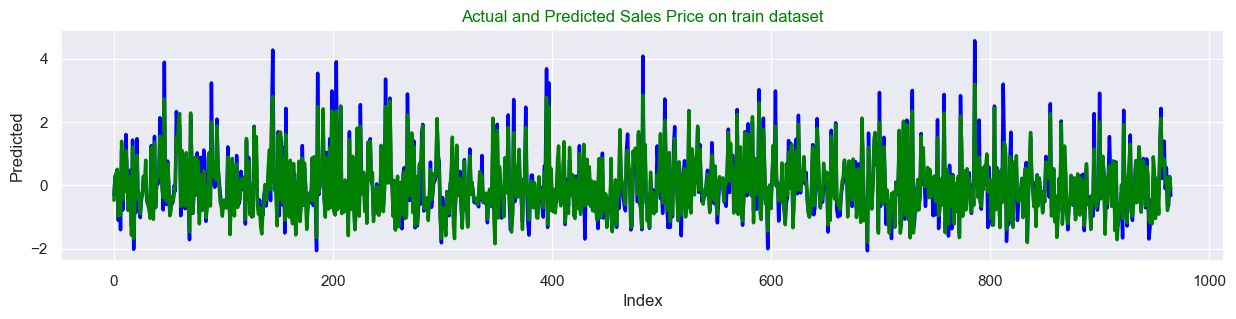

In [104]:
#Actual vs Predicted
c = [i for i in range(0,len(X_train),1)]
plt.figure(figsize=(15,3))
plt.plot(c,y_train, color="blue", linewidth=2.5, linestyle="-") #actual values
plt.plot(c,y_train_pred, color="green",  linewidth=2.5, linestyle="-") #predicted values
plt.title('Actual and Predicted Sales Price on train dataset' ,
            fontdict={'fontsize':12,'fontweight':5,'color':'Green'})      
plt.xlabel('Index')                               
plt.ylabel('Predicted')    
plt.show()

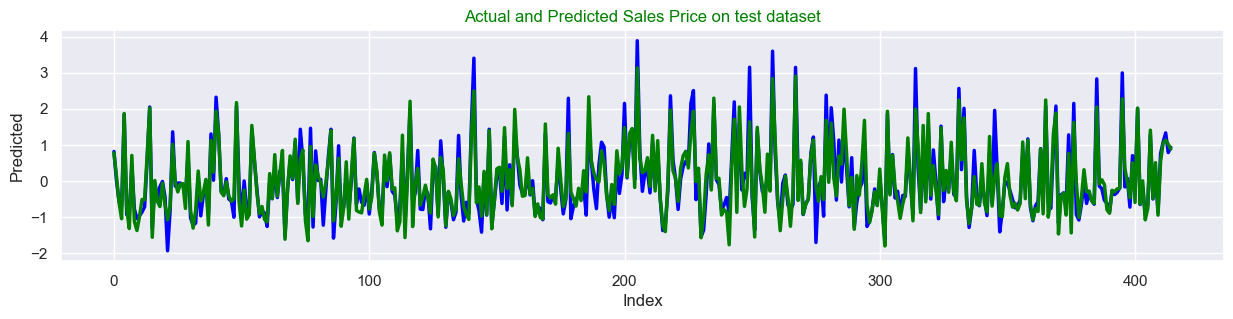

In [105]:
#Actual vs Predicted
c = [i for i in range(0,len(X_test),1)]
plt.figure(figsize=(15,3))
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #actual values
plt.plot(c,y_test_pred, color="green",  linewidth=2.5, linestyle="-") #predicted values
plt.title('Actual and Predicted Sales Price on test dataset' ,
            fontdict={'fontsize':12,'fontweight':5,'color':'Green'})      
plt.xlabel('Index')                               
plt.ylabel('Predicted')    
plt.show()

In [106]:
#build final table with constants & all coefficients
y_list = []
y_list = [lasso.intercept_]
y_list.extend(lasso.coef_)
model['Lasso'] = y_list

**3.3 Find optimal value for hyper parameter using VIF**

In [107]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_vif, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [108]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.01}


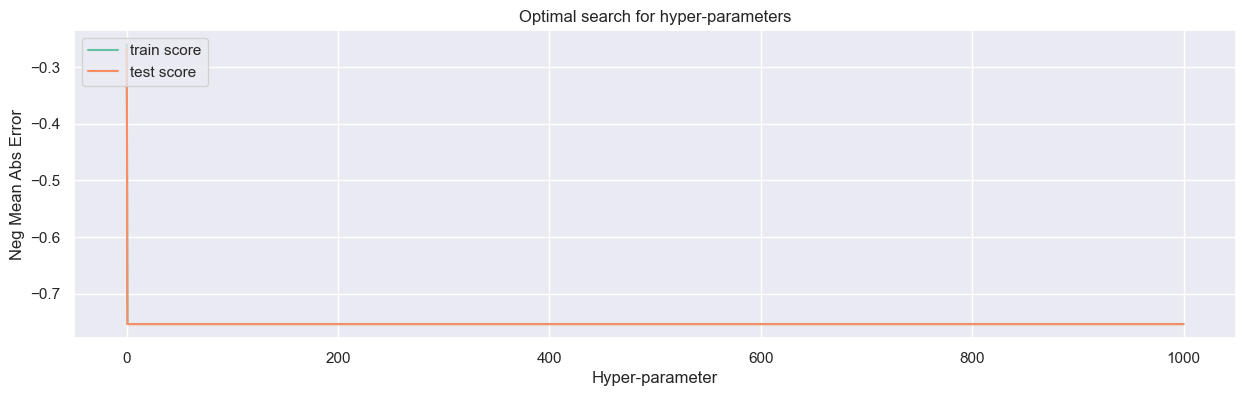

In [109]:
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(15,4))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('Hyper-parameter')
plt.ylabel('Neg Mean Abs Error')
plt.title("Optimal search for hyper-parameters")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

**3.4 Build final model using VIF**

In [110]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised
lasso = Lasso(alpha=list(model_cv.best_params_.values())[0])
        
lasso.fit(X_train_vif, y_train) 

Lasso(alpha=0.01)

**3.5 Predict using final model without VIF & calculate metrics**

In [111]:
y_train_vif_pred = lasso.predict(X_train_vif)
y_test_vif_pred = lasso.predict(X_test_vif)

metric.append(calc_metrics('Lasso[Train]',y_train,y_train_pred))
metric.append(calc_metrics('Lasso[Test]',y_test,y_test_pred))
metric.append(calc_metrics('Lasso-VIF[Train]',y_train,y_train_vif_pred))
metric.append(calc_metrics('Lasso-VIF[Test]',y_test,y_test_vif_pred))

In [112]:
#build final table with constants & all coefficients
y_list = []
y_list = [lasso.intercept_]
y_list.extend(lasso.coef_)
model_vif['Lasso'] = y_list

**4. Comparison of metrics & coefficents between MLR, Ridge & Lasso**

**4.1 Metric comparison across models with & without VIF**

In [113]:
#print the metrics comparison
metric_df = pd.DataFrame(metric,columns=['Model','R2','RSS','RMSE','Adj_R2'])
metric_df

,Model,R2,RSS,RMSE,Adj_R2
0,MLR[Train],0.8835,112.5651,0.3414,0.8771
1,MLR[Test],0.8682,54.6839,0.3630,0.8610
2,MLR-VIF[Train],0.8631,132.2780,0.3700,0.8556
3,MLR-VIF[Test],0.8607,57.8011,0.3732,0.8531
4,Ridge[Train],0.8811,114.8585,0.3448,0.8746
5,Ridge[Test],0.8696,54.1280,0.3611,0.8624
6,Ridge-VIF[Train],0.8621,133.1716,0.3713,0.8546
7,Ridge-VIF[Test],0.8609,57.7091,0.3729,0.8533
8,Lasso[Train],0.8759,119.8348,0.3522,0.8692
9,Lasso[Test],0.8727,52.8241,0.3568,0.8658


**Observation**<br>
1. Lasso on the test data set without manual VIF tuning has the best performance at a value of R2 of 87.2 with least errors
created. <br>
2. Lasso with VIF manual tuning is the best among the VIF models.<br>
3. Overall, for this dataset, Lasso regularization has done quite well.

**4.2 Model coefficients comparison between models without VIF**

In [114]:
#get the variable and coeffiencts together
betas = pd.DataFrame()
y_list=[]
y_list = ['const']
y_list.extend(X_train.columns)
betas['Features'] = y_list
betas['Linear'] = model['MLR']
betas['Ridge'] = model['Ridge']
betas['Lasso'] = model['Lasso']
pd.set_option('display.max_rows', None)
betas

,Features,Linear,Ridge,Lasso
0,const,-2.316672e-16,-2.283375e-16,-2.389780e-16
1,LotArea,6.039961e-02,6.424728e-02,5.673643e-02
2,BsmtUnfSF,-1.161862e-01,-8.015587e-02,-7.155358e-02
3,TotalBsmtSF,2.893960e-01,2.438750e-01,2.197939e-01
4,GrLivArea,3.455704e-01,2.969044e-01,3.869988e-01
5,FullBath,3.891409e-02,4.629382e-02,1.717248e-02
6,BedroomAbvGr,-6.224209e-02,-5.009055e-02,-2.255885e-02
7,KitchenAbvGr,-8.287411e-02,-8.153841e-02,-7.709997e-02
8,TotRmsAbvGrd,3.587400e-02,5.826339e-02,6.258410e-03
9,GarageCars,8.716565e-02,8.433923e-02,9.268135e-02


**Observation**<br>
For the large part, the coefficients of the features confirm the analysis drawn under EDA above.

**4.3 Model coefficients comparison between models with VIF**

In [115]:
betas_vif = pd.DataFrame()
y_list=[]
y_list = ['const']
y_list.extend(X_train_vif.columns)
betas_vif['Features'] = y_list
betas_vif['Linear'] = model_vif['MLR']
betas_vif['Ridge'] = model_vif['Ridge']
betas_vif['Lasso'] = model_vif['Lasso']
pd.set_option('display.max_rows', None)
betas_vif

,Features,Linear,Ridge,Lasso
0,const,-2.242022e-16,-2.248212e-16,-2.252950e-16
1,LotArea,8.609208e-02,9.342323e-02,8.117202e-02
2,BsmtUnfSF,-9.191171e-02,-7.547342e-02,-7.079504e-02
3,TotalBsmtSF,2.317149e-01,2.183260e-01,2.214995e-01
4,GrLivArea,4.008651e-01,3.753846e-01,3.957677e-01
5,KitchenAbvGr,-9.119247e-02,-8.786779e-02,-8.639466e-02
6,GarageCars,1.399255e-01,1.468325e-01,1.379016e-01
7,AgeBuiltYr,-2.337644e-01,-2.126127e-01,-2.210593e-01
8,OverallQual_Very Good,1.268056e-01,1.260982e-01,1.207678e-01
9,OverallCond_Avg,-9.963635e-02,-8.282055e-02,-7.340420e-02


**Observation**<br>
With VIF, these models are least complex, however Lasso regularization could only identiy 5 features to be very close
to zero but not completely zero unlike the models created manual VIf intervention.

**4.4 Find all the features whose coefficients are zero and are irrelevant for the final Lasso model**

In [116]:
#find the betas whose coefficients are zero for Lasso model for non VIF models
betas[betas['Lasso'] == 0]

,Features,Linear,Ridge,Lasso
13,AgeGarageYr,0.026703,0.017404,0.0
14,MSSubClass_2_StoryNew,-0.032619,-0.008533,0.0
17,LotShape_Regular,0.025369,0.009529,-0.0
22,HouseStyle_Others,0.035585,0.023758,0.0
23,OverallQual_Good,0.014798,0.012921,0.0
29,Exterior1st_VinylSiding,-0.103822,-0.030699,0.0
30,Exterior1st_WoodSiding,-0.052111,-0.038567,-0.0
31,Exterior2nd_VinylSiding,0.109774,0.031082,0.0
43,BsmtFinType1_Unfin,0.033531,0.006402,0.0
49,GarageFinish_RoughFin,-0.021593,-0.021124,-0.0


**Observation**<br>
1. Ignore data wrt VIF ie betas_vif table as there is slight difference when using VIF. Therefore, we focus on using on
models created without VIF(betas table).<br>
2. The hyper-parameter for ridge is optimal at a value of 50 and for lasso it is 0.01.<br>
3. The best model is the Lasso with the highest R2 value of 87.3, least RSS and RMSE values of 52.7 and 0.35 and highest
adjusted R2 of 86.6. On top of this, lasso also made the coefficents of 10 features(noted above) as 0 which reduced the 
complexity of the overall mode.

### VI. Equations of MLR, Ridge & Lasso models(non VIF)

**1 Multiple Linear Regression equation**

In [117]:
#MLR
y_list=[]
y_list=betas.apply(lambda x : '('+str(round(x.Linear,4))+')'+'*'+x.Features if (x.Linear !=0 and round(x.Linear,4))>0
                                else str(0) ,axis=1 )
x_str = ''
for i in range(len(y_list)):
    if y_list[i] =='0':
        continue
    else:        
        x_str = x_str + '+' + y_list[i]

print('\033[1m{:10s}\033[0m'.format('Mutiple Linear Regression'))
Latex(x_str.lstrip('+'))

Mutiple Linear Regression


<IPython.core.display.Latex object>

**2 Ridge Regularization**

In [118]:
#Ridge
y_list=[]
y_list=betas.apply(lambda x : '('+str(round(x.Ridge,4))+')'+'*'+x.Features if (x.Ridge !=0 and round(x.Ridge,4))>0
                                else str(0) ,axis=1 )
x_str = ''
for i in range(len(y_list)):
    if y_list[i] =='0':
        continue
    else:        
        x_str = x_str + '+' + y_list[i]      

print('\033[1m{:10s}\033[0m'.format('Ridge Regularization'))
Latex(x_str.lstrip('+'))

Ridge Regularization


<IPython.core.display.Latex object>

**3 Lasso Regularization**

In [119]:
#Lasso
y_list=[]
y_list=betas.apply(lambda x : '('+str(round(x.Lasso,4))+')'+'*'+x.Features if (x.Lasso !=0 and round(x.Lasso,4))>0
                                else str(0) ,axis=1 )
x_str = ''
for i in range(len(y_list)):
    if y_list[i] =='0':
        continue
    else:        
        x_str = x_str + '+' + y_list[i]      

print('\033[1m{:10s}\033[0m'.format('Lasso Regularization'))
Latex(x_str.lstrip('+'))

Lasso Regularization


<IPython.core.display.Latex object>

**Observation**<br>
As can be observed, the Lasso regularization equation is much simplier both in terms of number of features and the value
of the coefficients when compared to Ridge & MLR equations.

### VII. Subjective Questions

**1. Question 1**

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose 
double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change 
is implemented?

**Answer:**<br>
Optimal value found for ridge is 50 and for lasso regression is 0.01 in the dataset provided for the assignment.

In [120]:
#most important predicators for Ridge with alpha = 50
x_list=[]
for pos,coef in betas['Ridge'].sort_values(ascending=False).items():
    x_list.append(betas.iloc[pos]['Features'])    

print('The top predictors for Ridge with alpha=50 are : ', list(x_list[:10]))

The top predictors for Ridge with alpha=50 are :  ['GrLivArea', 'TotalBsmtSF', 'OverallQual_Very Good', 'ExterQual_Others', 'BsmtQual_Others', 'GarageCars', 'LotArea', 'Foundation_PouredContrete', 'GarageArea', 'HouseStyle_2 Story']


In [121]:
#most important predicators for Lasso with alpha = 0.01
x_list=[]
for pos,coef in betas['Lasso'].sort_values(ascending=False).items():
    x_list.append(betas.iloc[pos]['Features'])    

print('The top predictors for Lasso with alpha=0.01 are : ', list(x_list[:10]))

The top predictors for Lasso with alpha=0.01 are :  ['GrLivArea', 'TotalBsmtSF', 'OverallQual_Very Good', 'GarageCars', 'ExterQual_Others', 'BsmtQual_Others', 'LotArea', 'KitchenQual_Others', 'Foundation_PouredContrete', 'BsmtFinType1_GoodLivQtr']


Double the alpha for both ridge & lasso regression & pick the top 10 predictors.

In [122]:
#Ridge with alpha = 50*2 = 100
ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

#calc metric
metric.append(calc_metrics('Ridge-x2[Train]',y_train,y_train_pred))
metric.append(calc_metrics('Ridge-x2[Test]',y_test,y_test_pred))

#build final table with constants & all coefficients
y_list = []
model_1= pd.DataFrame()
y_list = [ridge.intercept_]
y_list.extend(ridge.coef_)
model_1['Ridge'] = y_list

#built the table for display
betas_model_1 = pd.DataFrame()
y_list=[]
y_list = ['const']
y_list.extend(X_train.columns)
betas_model_1['Features'] = y_list
betas_model_1['Ridge'] = model_1['Ridge']

#most important predicators for Ridge with alpha = 100
x_list=[]
for pos,coef in betas_model_1['Ridge'].sort_values(ascending=False).items():
    x_list.append(betas_model_1.iloc[pos]['Features'])    

print('The top predictors for Ridge with alpha=100 are : ', list(x_list[:10]))

The top predictors for Ridge with alpha=100 are :  ['GrLivArea', 'TotalBsmtSF', 'OverallQual_Very Good', 'ExterQual_Others', 'BsmtQual_Others', 'GarageCars', 'GarageArea', 'TotRmsAbvGrd', 'LotArea', 'KitchenQual_Others']


In [123]:
#Lasso with alpha = 0.01*2 = 0.02
lasso = Lasso(alpha=0.02)        
lasso.fit(X_train, y_train) 

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

#metrics
metric.append(calc_metrics('Lasso-x2[Train]',y_train,y_train_pred))
metric.append(calc_metrics('Lasso-x2[Test]',y_test,y_test_pred))

#build final table with constants & all coefficients
y_list = []
model_1= pd.DataFrame()
y_list = [lasso.intercept_]
y_list.extend(lasso.coef_)
model_1['Lasso'] = y_list

#built the table for display
y_list=[]
betas_model_1['Lasso'] = model_1['Lasso']

#most important predicators for Ridge with alpha = 100
x_list=[]
for pos,coef in betas_model_1['Lasso'].sort_values(ascending=False).items():
    x_list.append(betas_model_1.iloc[pos]['Features'])    

print('The top predictors for Lasso with alpha=0.02 are : ', list(x_list[:10]))

The top predictors for Lasso with alpha=0.02 are :  ['GrLivArea', 'TotalBsmtSF', 'OverallQual_Very Good', 'GarageCars', 'ExterQual_Others', 'BsmtQual_Others', 'BsmtFinType1_GoodLivQtr', 'GarageArea', 'LotArea', 'KitchenQual_Others']


In [124]:
metric_df = pd.DataFrame(metric,columns=['Model','R2','RSS','RMSE','Adj_R2'])
metric_df.iloc[[4,5,12,13]]

,Model,R2,RSS,RMSE,Adj_R2
4,Ridge[Train],0.8811,114.8585,0.3448,0.8746
5,Ridge[Test],0.8696,54.1280,0.3611,0.8624
12,Ridge-x2[Train],0.8776,118.2719,0.3499,0.8709
13,Ridge-x2[Test],0.8681,54.7501,0.3632,0.8609


In [125]:
metric_df.iloc[[8,9,14,15]]

,Model,R2,RSS,RMSE,Adj_R2
8,Lasso[Train],0.8759,119.8348,0.3522,0.8692
9,Lasso[Test],0.8727,52.8241,0.3568,0.8658
14,Lasso-x2[Train],0.8682,127.3176,0.3630,0.8610
15,Lasso-x2[Test],0.8720,53.1351,0.3578,0.8650


In [126]:
betas_model_1

,Features,Ridge,Lasso
0,const,-2.288540e-16,-2.449390e-16
1,LotArea,6.656092e-02,5.458339e-02
2,BsmtUnfSF,-5.940995e-02,-4.796985e-02
3,TotalBsmtSF,2.171185e-01,1.996703e-01
4,GrLivArea,2.651915e-01,3.830650e-01
5,FullBath,5.049164e-02,6.450258e-03
6,BedroomAbvGr,-4.098664e-02,-2.901414e-03
7,KitchenAbvGr,-7.822928e-02,-7.199576e-02
8,TotRmsAbvGrd,6.902024e-02,0.000000e+00
9,GarageCars,8.405749e-02,8.681462e-02


Detailed answer provided in the pdf file.

**Question 2**

You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will 
you choose to apply and why?

Lasso model with alpha = 0.01. Detailed answer provided in pdf.

**Question 3**

After building the model, you realised that the five most important predictor variables in the lasso model are not 
available in the incoming data. You will now have to create another model excluding the five most important predictor 
variables. Which are the five most important predictor variables now?

In [127]:
#copy the dataset and drop the features
X_train_lasso = X_train.copy()
X_train_lasso.drop(['GrLivArea','TotalBsmtSF','OverallQual_Very Good','GarageCars','ExterQual_Others'],axis=1,inplace=True)
X_test_lasso = X_test.copy()
X_test_lasso.drop(['GrLivArea','TotalBsmtSF','OverallQual_Very Good','GarageCars','ExterQual_Others'],axis=1,inplace=True)
print('X_train_old: ',X_train.shape)
print('X_train_new: ',X_train_lasso.shape)
print('X_test_old: ',X_test.shape)
print('X_test_new: ',X_test_lasso.shape)

X_train_old:  (966, 50)
X_train_new:  (966, 45)
X_test_old:  (415, 50)
X_test_new:  (415, 45)


In [128]:
#build lasso model
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_lasso, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [129]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.01}


In [130]:
lasso = Lasso(alpha=list(model_cv.best_params_.values())[0])
        
lasso.fit(X_train_lasso, y_train) 

print(lasso.intercept_)
print(lasso.coef_)

-1.8450165169332882e-16
[ 0.13037309  0.05431166  0.0996409  -0.03812718 -0.10452124  0.26905784
  0.21384108 -0.14088888 -0.02526496  0.         -0.         -0.
 -0.01978944 -0.          0.         -0.00164267 -0.          0.01543766
 -0.00352025 -0.0270294   0.         -0.05862103  0.01378574 -0.03773302
 -0.03107054 -0.00835598 -0.          0.03583426 -0.14212492 -0.
  0.04756591  0.11927096 -0.         -0.          0.0783618   0.09060319
 -0.00780092 -0.0704257  -0.01760605 -0.01665567 -0.03059709  0.10501755
 -0.03244049 -0.0064582  -0.05052397]


In [131]:
#predict
y_train_pred = lasso.predict(X_train_lasso)
y_test_pred = lasso.predict(X_test_lasso)

#build final table with constants & all coefficients
y_list = []
model_1= pd.DataFrame()
y_list = [lasso.intercept_]
y_list.extend(lasso.coef_)
model_1['Lasso_drop'] = y_list

#built the table for display
betas_model_1 = pd.DataFrame()
y_list=[]
y_list = ['const']
y_list.extend(X_train_lasso.columns)
betas_model_1['Features'] = y_list
betas_model_1['Lasso_drop'] = model_1['Lasso_drop']

#metrics
metric.append(calc_metrics('Lasso_drop[Train]',y_train,y_train_pred))
metric.append(calc_metrics('Lasso_drop[Test]',y_test,y_test_pred))

#display metric table
metric_df = pd.DataFrame(metric,columns=['Model','R2','RSS','RMSE','Adj_R2'])
metric_df

,Model,R2,RSS,RMSE,Adj_R2
0,MLR[Train],0.8835,112.5651,0.3414,0.8771
1,MLR[Test],0.8682,54.6839,0.3630,0.8610
2,MLR-VIF[Train],0.8631,132.2780,0.3700,0.8556
3,MLR-VIF[Test],0.8607,57.8011,0.3732,0.8531
4,Ridge[Train],0.8811,114.8585,0.3448,0.8746
5,Ridge[Test],0.8696,54.1280,0.3611,0.8624
6,Ridge-VIF[Train],0.8621,133.1716,0.3713,0.8546
7,Ridge-VIF[Test],0.8609,57.7091,0.3729,0.8533
8,Lasso[Train],0.8759,119.8348,0.3522,0.8692
9,Lasso[Test],0.8727,52.8241,0.3568,0.8658


In [132]:
#most important predicators for Lasso with alpha = 0.01
x_list=[]
for pos,coef in betas_model_1['Lasso_drop'].sort_values(ascending=False).items():
    x_list.append(betas_model_1.iloc[pos]['Features'])    

print('The top predictors for Lasso with alpha=0.01 are : ', list(x_list[:5]))

The top predictors for Lasso with alpha=0.01 are :  ['TotRmsAbvGrd', 'GarageArea', 'LotArea', 'BsmtQual_Others', 'KitchenQual_Others']


**Question 4**

How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of 
the model and why?

Answered in detail in the pdf.